In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 2
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 3e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
perceptual_ext = PerceptualLoss()

In [15]:
sobel_filter = Sobel().to(device)

In [16]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)
    
    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    edge_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        edge_x = sobel_filter(x)
        
        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()
        
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr.detach(), edge_y_pr.detach()), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.zeros(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        # Perceptual loss
        perceptual_loss = perceptual_ext(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())
        
        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + air_loss + bone_loss + perceptual_loss + _mae 
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _dis.item()
        gen_l += _gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        mae_l += _mae.item()
        perceptual_l += perceptual_loss.item()
        
    return  perceptual_l/(index+1), mae_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [17]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    cont_ = []
    edge_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        edge_x = sobel_filter(x)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.zeros(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.ones(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(acc_)/len(acc_)

In [18]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [19]:
from codes.activation import Activation
import torchvision.models as models

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = models.resnet18()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=512, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Generator

In [21]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [22]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [23]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [24]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [25]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [26]:
len(trainset), len(testset)

(1344, 191)

In [27]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7ff0721aa970>,)

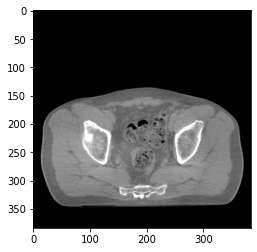

In [28]:
plt.imshow(x.squeeze(), 'gray'),

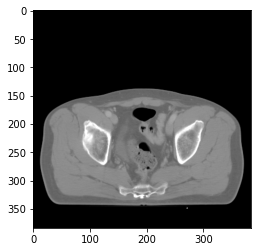

In [29]:
plt.imshow(y.squeeze(), 'gray')

In [30]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [31]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = Generator(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 attention_type=DECODER_ATT)

In [34]:
discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [35]:
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
replace_relu_to_leakyReLU(discriminator)

In [36]:
model

Generator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slo

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [38]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_perceptual, loss_mae, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_cont_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_cont_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        wandb.log({
            "loss mae": loss_mae,
            "loss perceptual": loss_perceptual,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "loss bone": loss_bone,
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test + score_cont_test >  max_score:
            max_score = score_bone_test +  score_air_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [02:17,  1.22it/s]
168it [00:27,  6.04it/s]
24it [00:04,  5.61it/s]
168it [02:15,  1.24it/s]
168it [00:27,  6.04it/s]
24it [00:04,  5.63it/s]
168it [02:17,  1.22it/s]
168it [00:27,  6.03it/s]
24it [00:04,  5.64it/s]
168it [02:17,  1.22it/s]
168it [00:27,  6.03it/s]
24it [00:04,  5.67it/s]
168it [02:18,  1.21it/s]
168it [00:29,  5.72it/s]
24it [00:04,  5.23it/s]
168it [02:20,  1.20it/s]
168it [00:27,  6.04it/s]
24it [00:04,  5.64it/s]
168it [02:17,  1.22it/s]
168it [00:28,  5.99it/s]
24it [00:04,  5.61it/s]
168it [02:17,  1.22it/s]
168it [00:27,  6.02it/s]
24it [00:04,  5.61it/s]
168it [02:18,  1.21it/s]
168it [00:27,  6.01it/s]
24it [00:04,  5.62it/s]
168it [02:18,  1.21it/s]
168it [00:28,  5.99it/s]
24it [00:10,  2.23it/s]
168it [02:17,  1.22it/s]
168it [00:27,  6.03it/s]
24it [00:04,  5.69it/s]
168it [02:17,  1.22it/s]
168it [00:27,  6.06it/s]
24it [00:04,  5.67it/s]
168it [02:17,  1.22it/s]
168it [00:27,  6.03it/s]
24it [00:04,  5.51it/s]
168it [02:18,  1.21it/s]
168it [00:28,

In [39]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [40]:
model = model = Generator(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [41]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8366336822509766
psnr score = 21.307971954345703
snr score = 11.37091064453125
mae error = 0.029725154861807823
air dice score = 0.9917353743708032
bone dice score = 2.9036004644917653e-11
contour dice score = 0.17318099737167358


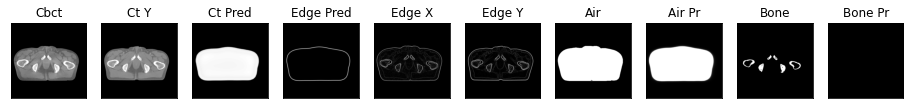

1it [00:00,  1.57it/s]

ssim score = 0.8387838006019592
psnr score = 21.311796188354492
snr score = 11.422269821166992
mae error = 0.029656652361154556
air dice score = 0.9923327959737425
bone dice score = 2.8868360276302878e-11
contour dice score = 0.16284680366516113


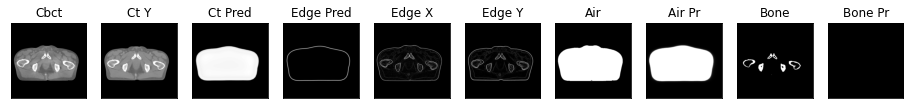

2it [00:01,  1.52it/s]

ssim score = 0.8351728320121765
psnr score = 20.979516983032227
snr score = 11.252884864807129
mae error = 0.031095845624804497
air dice score = 0.992398391173094
bone dice score = 2.3963575364870272e-11
contour dice score = 0.19565217196941376


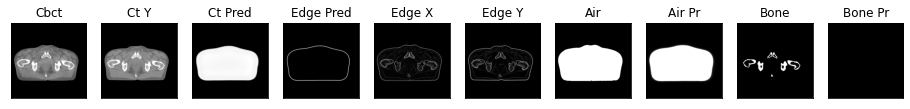

3it [00:01,  1.67it/s]

ssim score = 0.8318125009536743
psnr score = 20.800039291381836
snr score = 11.1626615524292
mae error = 0.0322909839451313
air dice score = 0.9919323857088055
bone dice score = 2.1473051320131565e-11
contour dice score = 0.24077434837818146


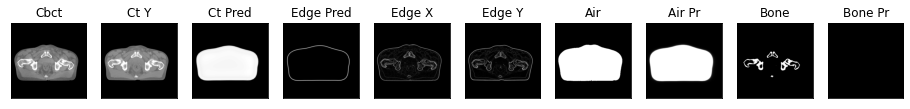

4it [00:02,  1.82it/s]

ssim score = 0.8278336524963379
psnr score = 20.790409088134766
snr score = 11.193334579467773
mae error = 0.03319587558507919
air dice score = 0.9914349222030215
bone dice score = 1.9286403085452526e-11
contour dice score = 0.28155338764190674


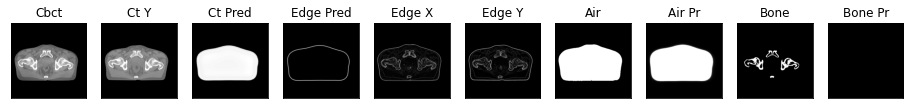

5it [00:02,  1.91it/s]

ssim score = 0.8265301585197449
psnr score = 20.512725830078125
snr score = 11.05218505859375
mae error = 0.03487067297101021
air dice score = 0.9918222098867086
bone dice score = 1.6329196603260463e-11
contour dice score = 0.35909920930862427


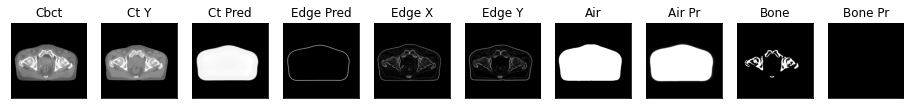

6it [00:03,  1.97it/s]

ssim score = 0.8278946280479431
psnr score = 20.486459732055664
snr score = 11.001863479614258
mae error = 0.0347617082297802
air dice score = 0.9911208107865794
bone dice score = 1.563966218305224e-11
contour dice score = 0.36263737082481384


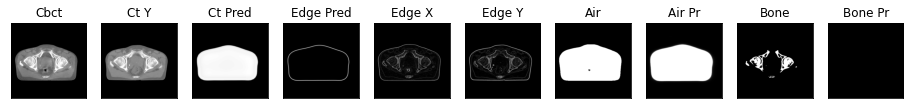

7it [00:03,  2.04it/s]

ssim score = 0.8361873626708984
psnr score = 20.857196807861328
snr score = 11.187061309814453
mae error = 0.032286472618579865
air dice score = 0.9907184668430853
bone dice score = 1.7394329448297195e-11
contour dice score = 0.3323114514350891


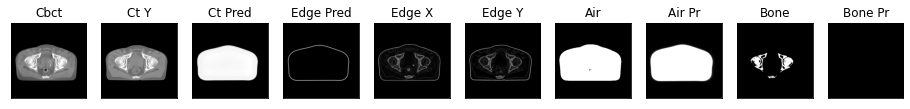

8it [00:04,  2.04it/s]

ssim score = 0.8418665528297424
psnr score = 21.051776885986328
snr score = 11.287087440490723
mae error = 0.03100568801164627
air dice score = 0.991265582765168
bone dice score = 1.898974553704919e-11
contour dice score = 0.25353845953941345


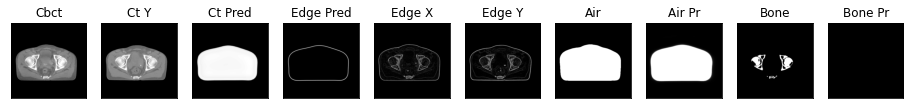

9it [00:04,  2.02it/s]

ssim score = 0.8484407067298889
psnr score = 21.149860382080078
snr score = 11.369887351989746
mae error = 0.030173594132065773
air dice score = 0.9910784064958224
bone dice score = 1.9920318724702783e-11
contour dice score = 0.2271604984998703


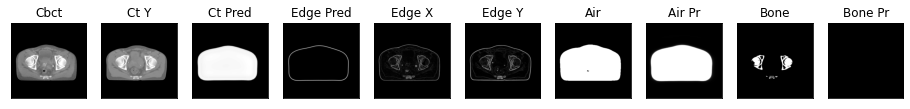

10it [00:05,  1.98it/s]

ssim score = 0.8556709289550781
psnr score = 21.06725311279297
snr score = 11.319549560546875
mae error = 0.029876060783863068
air dice score = 0.992352051040865
bone dice score = 2.105706464474506e-11
contour dice score = 0.22126081585884094


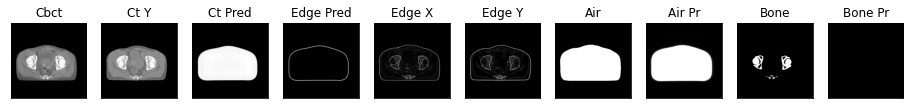

11it [00:05,  1.73it/s]

ssim score = 0.8631200194358826
psnr score = 20.9896240234375
snr score = 11.265631675720215
mae error = 0.029746783897280693
air dice score = 0.9888614371011026
bone dice score = 2.107481559491939e-11
contour dice score = 0.22029702365398407


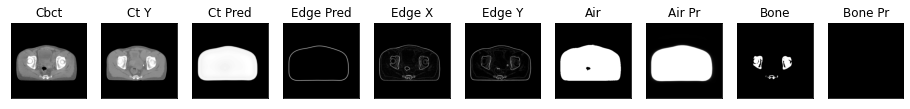

12it [00:06,  1.85it/s]

ssim score = 0.8688074946403503
psnr score = 21.066680908203125
snr score = 11.31076717376709
mae error = 0.02876189723610878
air dice score = 0.9863255495218757
bone dice score = 2.2583559168415004e-11
contour dice score = 0.3011152446269989


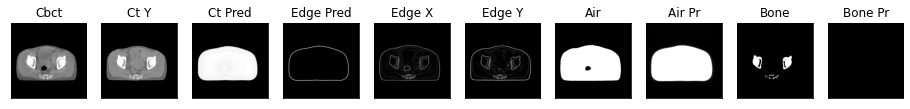

13it [00:06,  1.95it/s]

ssim score = 0.8643727898597717
psnr score = 21.6368408203125
snr score = 11.738967895507812
mae error = 0.02723904885351658
air dice score = 0.9854623799862097
bone dice score = 2.4467824809775684e-11
contour dice score = 0.2817955017089844


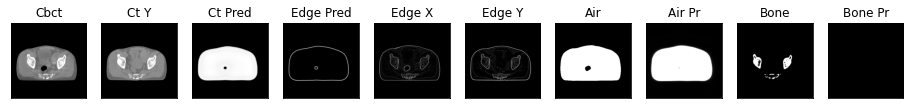

14it [00:07,  2.03it/s]

ssim score = 0.8650768399238586
psnr score = 22.075136184692383
snr score = 12.09160041809082
mae error = 0.025905881077051163
air dice score = 0.9865401008177109
bone dice score = 2.5920165888389833e-11
contour dice score = 0.22928348183631897


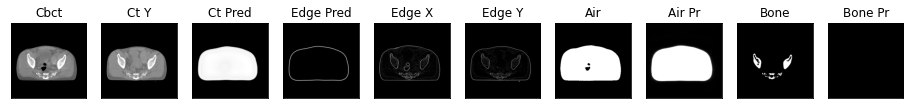

15it [00:07,  2.08it/s]

ssim score = 0.8590269088745117
psnr score = 21.754459381103516
snr score = 11.794412612915039
mae error = 0.027335310354828835
air dice score = 0.9870493227919339
bone dice score = 2.4770869456904362e-11
contour dice score = 0.26801517605781555


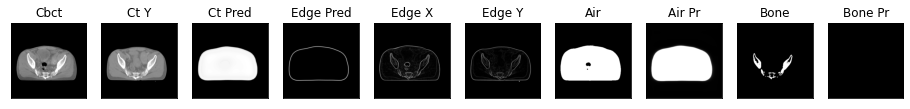

16it [00:08,  2.11it/s]

ssim score = 0.8535417914390564
psnr score = 21.412839889526367
snr score = 11.450247764587402
mae error = 0.028268754482269287
air dice score = 0.9850720732281266
bone dice score = 2.3441162681119523e-11
contour dice score = 0.31578946113586426


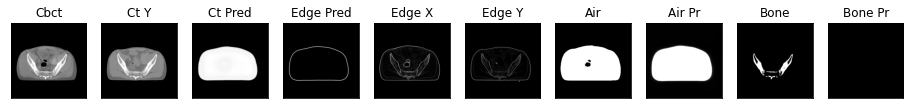

17it [00:08,  2.15it/s]

ssim score = 0.8514848351478577
psnr score = 21.539031982421875
snr score = 11.47468090057373
mae error = 0.028292933478951454
air dice score = 0.9833042127742366
bone dice score = 2.364625206848791e-11
contour dice score = 0.32624998688697815


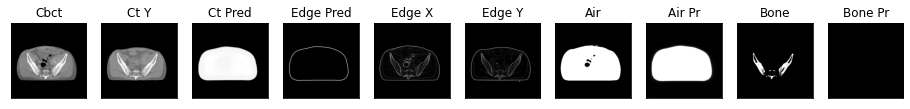

18it [00:09,  2.13it/s]

ssim score = 0.8463762402534485
psnr score = 21.367820739746094
snr score = 11.252786636352539
mae error = 0.029031191021203995
air dice score = 0.9837462899140198
bone dice score = 2.3331777880930195e-11
contour dice score = 0.38352638483047485


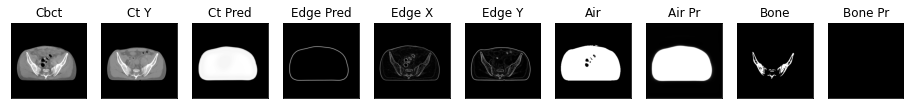

19it [00:09,  2.17it/s]

ssim score = 0.8440459370613098
psnr score = 21.119272232055664
snr score = 10.991928100585938
mae error = 0.02952072024345398
air dice score = 0.9855938697318165
bone dice score = 2.4113817216684018e-11
contour dice score = 0.3672424852848053


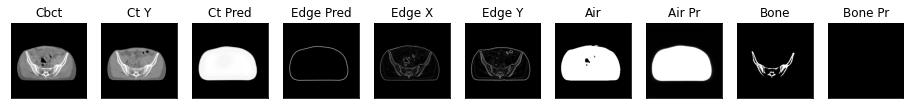

20it [00:09,  2.16it/s]

ssim score = 0.8419140577316284
psnr score = 21.03234100341797
snr score = 10.840149879455566
mae error = 0.029583994299173355
air dice score = 0.9865275582719173
bone dice score = 2.61780104705189e-11
contour dice score = 0.3731439709663391


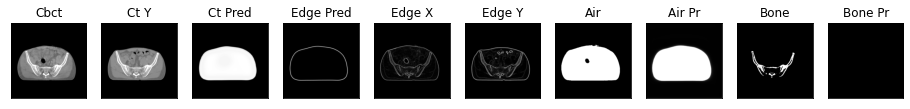

21it [00:10,  1.84it/s]

ssim score = 0.8375369906425476
psnr score = 20.764856338500977
snr score = 10.513235092163086
mae error = 0.03023725189268589
air dice score = 0.9873511073368189
bone dice score = 2.585315408412996e-11
contour dice score = 0.27622148394584656


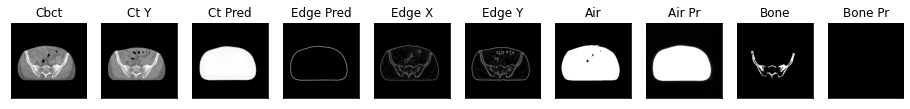

22it [00:11,  1.86it/s]

ssim score = 0.8356360793113708
psnr score = 20.5494327545166
snr score = 10.264383316040039
mae error = 0.03097880817949772
air dice score = 0.9882818685669175
bone dice score = 2.427184465960505e-11
contour dice score = 0.26439791917800903


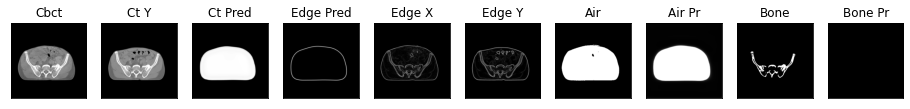

23it [00:11,  1.90it/s]

ssim score = 0.8381844162940979
psnr score = 20.456743240356445
snr score = 10.123128890991211
mae error = 0.03166697919368744
air dice score = 0.9894378661064098
bone dice score = 2.3337222869933788e-11
contour dice score = 0.2238507717847824


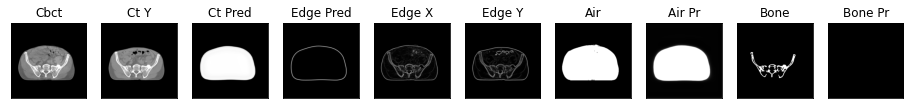

24it [00:12,  1.95it/s]

ssim score = 0.8352299928665161
psnr score = 20.368492126464844
snr score = 9.93787956237793
mae error = 0.032220762223005295
air dice score = 0.9881126173097113
bone dice score = 2.2416498542425095e-11
contour dice score = 0.14025624096393585


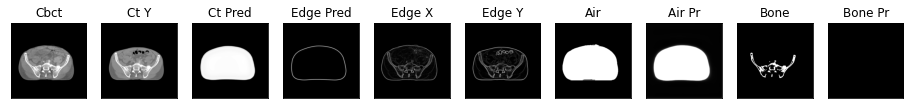

25it [00:12,  2.00it/s]

ssim score = 0.8344326019287109
psnr score = 20.306537628173828
snr score = 9.793190002441406
mae error = 0.03257337585091591
air dice score = 0.9881254295940033
bone dice score = 2.220248667801504e-11
contour dice score = 0.11732605844736099


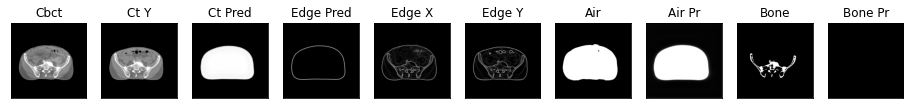

26it [00:13,  2.07it/s]

ssim score = 0.8382525444030762
psnr score = 20.297395706176758
snr score = 9.692861557006836
mae error = 0.03287498280405998
air dice score = 0.9865290983557206
bone dice score = 2.181025081740872e-11
contour dice score = 0.15266107022762299


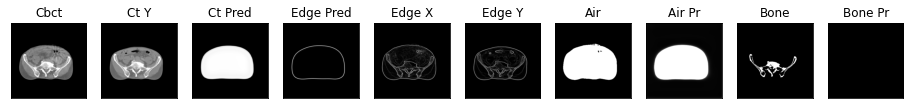

27it [00:13,  2.12it/s]

ssim score = 0.8393241763114929
psnr score = 20.306407928466797
snr score = 9.660767555236816
mae error = 0.03269413858652115
air dice score = 0.9864616740519665
bone dice score = 2.0768431982953927e-11
contour dice score = 0.11898016929626465


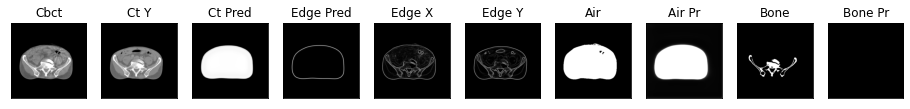

28it [00:14,  2.12it/s]

ssim score = 0.8057639598846436
psnr score = 20.042739868164062
snr score = 11.414896011352539
mae error = 0.04735611006617546
air dice score = 0.9868088619617321
bone dice score = 6.36132315481162e-11
contour dice score = 0.16038990020751953


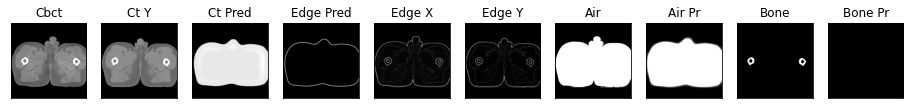

29it [00:14,  2.13it/s]

ssim score = 0.8066236972808838
psnr score = 20.24779510498047
snr score = 11.659210205078125
mae error = 0.047198254615068436
air dice score = 0.9874845630656446
bone dice score = 5.934718100537998e-11
contour dice score = 0.16246742010116577


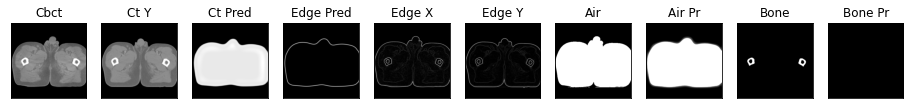

30it [00:14,  2.12it/s]

ssim score = 0.8061627149581909
psnr score = 20.281763076782227
snr score = 11.780625343322754
mae error = 0.047813501209020615
air dice score = 0.9889182315522472
bone dice score = 4.67508181371318e-11
contour dice score = 0.16629010438919067


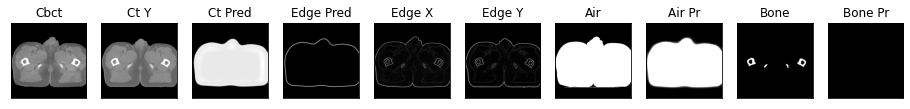

31it [00:15,  1.88it/s]

ssim score = 0.8031117916107178
psnr score = 20.28112030029297
snr score = 11.942540168762207
mae error = 0.048768311738967896
air dice score = 0.9911894539883669
bone dice score = 3.1867431484006776e-11
contour dice score = 0.1737918257713318


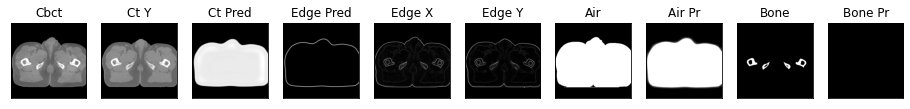

32it [00:16,  2.00it/s]

ssim score = 0.7926212549209595
psnr score = 20.06011962890625
snr score = 11.84968376159668
mae error = 0.049948800355196
air dice score = 0.9920141649201465
bone dice score = 2.7555800495245087e-11
contour dice score = 0.2012166529893875


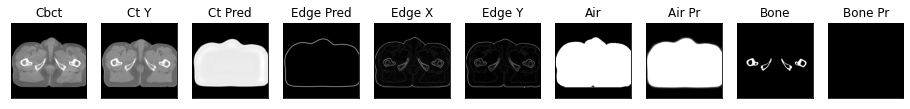

33it [00:16,  2.09it/s]

ssim score = 0.7911345958709717
psnr score = 19.955293655395508
snr score = 11.848097801208496
mae error = 0.050705552101135254
air dice score = 0.9925495794891528
bone dice score = 2.3986567521612218e-11
contour dice score = 0.16987329721450806


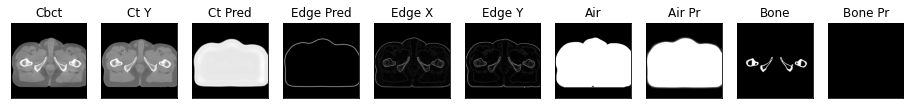

34it [00:16,  2.17it/s]

ssim score = 0.7909067273139954
psnr score = 19.825756072998047
snr score = 11.78565788269043
mae error = 0.05196031555533409
air dice score = 0.9923416771786808
bone dice score = 2.1953896816202988e-11
contour dice score = 0.1567339301109314


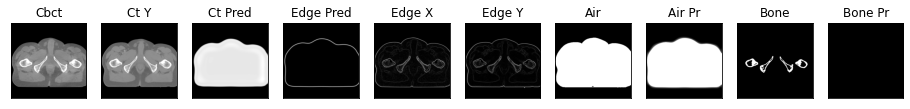

35it [00:17,  2.23it/s]

ssim score = 0.7882896065711975
psnr score = 19.795326232910156
snr score = 11.745339393615723
mae error = 0.05219808965921402
air dice score = 0.9925434962717525
bone dice score = 2.0733982997704042e-11
contour dice score = 0.15644028782844543


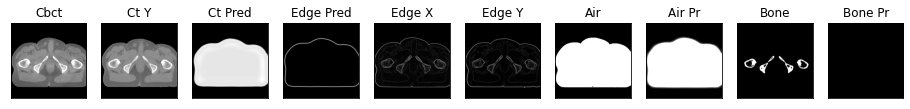

36it [00:17,  2.25it/s]

ssim score = 0.7905471324920654
psnr score = 19.82455062866211
snr score = 11.76090145111084
mae error = 0.051706064492464066
air dice score = 0.9926643384518407
bone dice score = 2.052966536603306e-11
contour dice score = 0.155503511428833


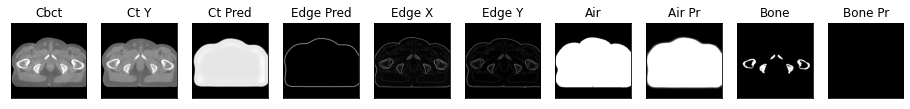

37it [00:18,  2.22it/s]

ssim score = 0.792921245098114
psnr score = 19.860553741455078
snr score = 11.808904647827148
mae error = 0.05171738564968109
air dice score = 0.992614598496781
bone dice score = 2.170609941346416e-11
contour dice score = 0.158462256193161


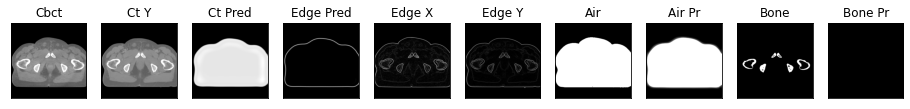

38it [00:18,  2.22it/s]

ssim score = 0.7896592020988464
psnr score = 19.866039276123047
snr score = 11.853473663330078
mae error = 0.0514182522892952
air dice score = 0.9927493235866565
bone dice score = 2.2311468094102822e-11
contour dice score = 0.15796896815299988


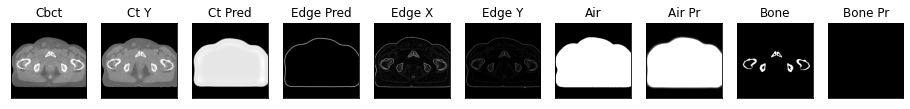

39it [00:19,  2.28it/s]

ssim score = 0.7819467186927795
psnr score = 19.511005401611328
snr score = 11.639728546142578
mae error = 0.05294022336602211
air dice score = 0.9925876690622762
bone dice score = 1.901140684374503e-11
contour dice score = 0.1659594476222992


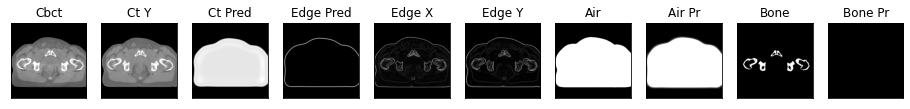

40it [00:19,  2.32it/s]

ssim score = 0.7713680267333984
psnr score = 19.22227668762207
snr score = 11.445686340332031
mae error = 0.054974690079689026
air dice score = 0.9933527779922934
bone dice score = 1.5703517587693097e-11
contour dice score = 0.16926713287830353


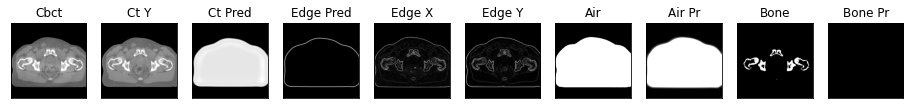

41it [00:20,  2.00it/s]

ssim score = 0.7596825361251831
psnr score = 19.40436553955078
snr score = 11.593728065490723
mae error = 0.05522771552205086
air dice score = 0.9942528393355959
bone dice score = 1.520450053192634e-11
contour dice score = 0.16208530962467194


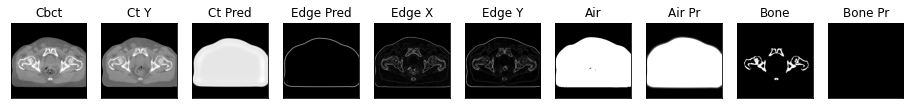

42it [00:20,  2.11it/s]

ssim score = 0.754266083240509
psnr score = 19.065000534057617
snr score = 11.326549530029297
mae error = 0.05764979124069214
air dice score = 0.9932343105995841
bone dice score = 1.2884937507887064e-11
contour dice score = 0.17577196657657623


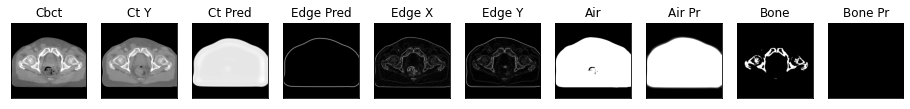

43it [00:21,  2.14it/s]

ssim score = 0.764625608921051
psnr score = 19.49949836730957
snr score = 11.624954223632812
mae error = 0.05422249436378479
air dice score = 0.9934842866913894
bone dice score = 1.669727834335119e-11
contour dice score = 0.17523810267448425


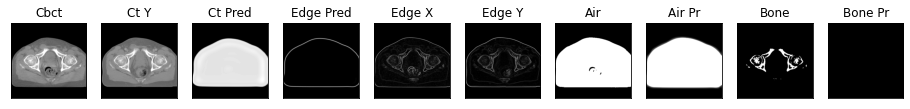

44it [00:21,  2.21it/s]

ssim score = 0.7732701301574707
psnr score = 19.885208129882812
snr score = 11.832099914550781
mae error = 0.05114278197288513
air dice score = 0.9937588396376914
bone dice score = 1.8821757951838475e-11
contour dice score = 0.22063037753105164


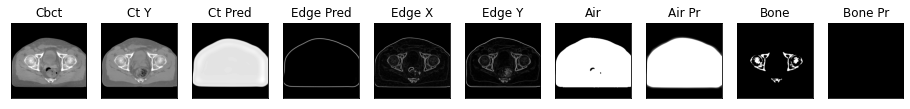

45it [00:21,  2.25it/s]

ssim score = 0.781369149684906
psnr score = 19.900129318237305
snr score = 11.75643539428711
mae error = 0.051302023231983185
air dice score = 0.9942275411499063
bone dice score = 2.1294718909256925e-11
contour dice score = 0.2593660056591034


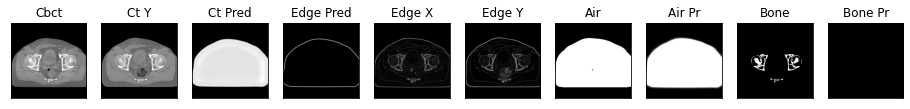

46it [00:22,  2.26it/s]

ssim score = 0.7878175973892212
psnr score = 19.67786979675293
snr score = 11.54986572265625
mae error = 0.052795469760894775
air dice score = 0.9945158276611009
bone dice score = 1.983339944427145e-11
contour dice score = 0.2037481963634491


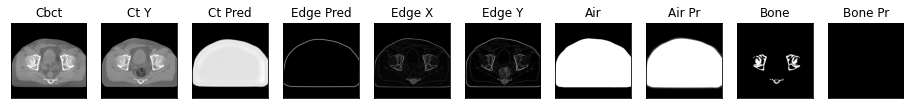

47it [00:22,  2.19it/s]

ssim score = 0.7885969281196594
psnr score = 19.424402236938477
snr score = 11.30643367767334
mae error = 0.05381803959608078
air dice score = 0.9942288921425121
bone dice score = 1.7966223499497554e-11
contour dice score = 0.2137698531150818


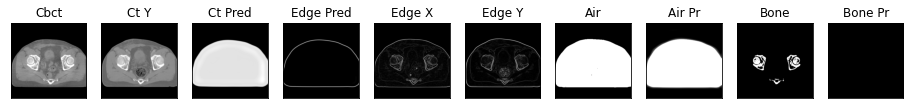

48it [00:23,  2.08it/s]

ssim score = 0.7923691868782043
psnr score = 19.066043853759766
snr score = 11.009664535522461
mae error = 0.0542922280728817
air dice score = 0.9944284577236304
bone dice score = 1.7488632388641332e-11
contour dice score = 0.20192307233810425


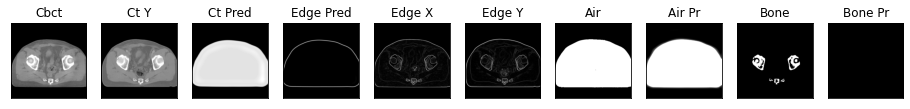

49it [00:23,  2.08it/s]

ssim score = 0.7951318025588989
psnr score = 18.90463638305664
snr score = 10.918340682983398
mae error = 0.054557058960199356
air dice score = 0.9947782120745441
bone dice score = 1.7155601303531385e-11
contour dice score = 0.18635927140712738


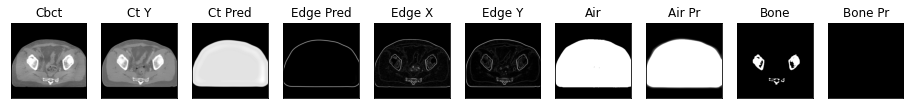

50it [00:24,  2.04it/s]

ssim score = 0.7879583239555359
psnr score = 19.263153076171875
snr score = 11.157750129699707
mae error = 0.05317014455795288
air dice score = 0.9947186014414999
bone dice score = 1.8978933383583622e-11
contour dice score = 0.18443803489208221


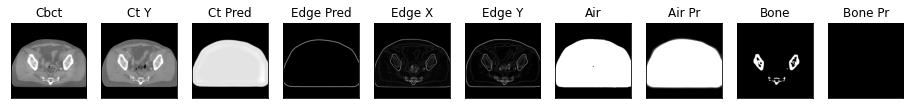

51it [00:25,  1.69it/s]

ssim score = 0.7792978286743164
psnr score = 18.79400634765625
snr score = 10.770231246948242
mae error = 0.057011716067790985
air dice score = 0.9943859090603013
bone dice score = 1.6531658125036674e-11
contour dice score = 0.1768970489501953


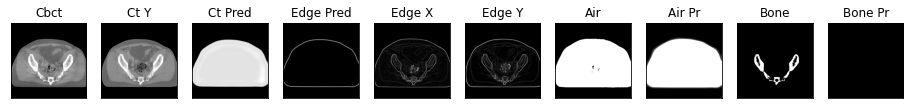

52it [00:26,  1.38it/s]

ssim score = 0.7707244157791138
psnr score = 18.608354568481445
snr score = 10.664728164672852
mae error = 0.05854465439915657
air dice score = 0.9940165049313551
bone dice score = 1.3825521913261087e-11
contour dice score = 0.16658595204353333


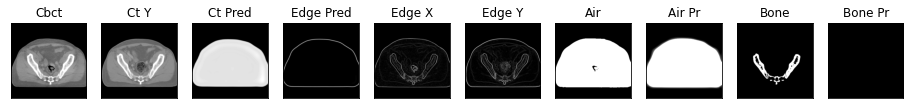

53it [00:27,  1.21it/s]

ssim score = 0.753429651260376
psnr score = 18.392290115356445
snr score = 10.47021770477295
mae error = 0.060796644538640976
air dice score = 0.9932689958465715
bone dice score = 1.3865779256601972e-11
contour dice score = 0.14111922681331635


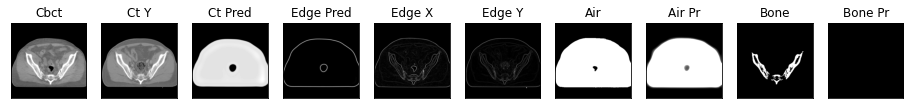

54it [00:28,  1.07it/s]

ssim score = 0.764093279838562
psnr score = 18.877431869506836
snr score = 10.96789836883545
mae error = 0.05794140323996544
air dice score = 0.9943881103005755
bone dice score = 1.4076576576378426e-11
contour dice score = 0.15615907311439514


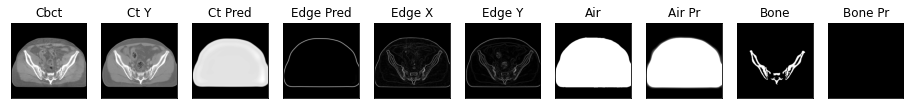

55it [00:29,  1.03it/s]

ssim score = 0.8388695120811462
psnr score = 20.612186431884766
snr score = 10.492396354675293
mae error = 0.033648986369371414
air dice score = 0.9909555082291589
bone dice score = 5.464480874018334e-11
contour dice score = 0.1293920874595642


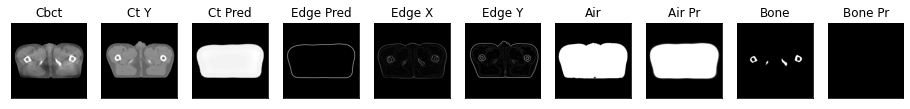

56it [00:30,  1.20it/s]

ssim score = 0.8300434350967407
psnr score = 20.1011962890625
snr score = 10.194385528564453
mae error = 0.03621232509613037
air dice score = 0.9922531466052187
bone dice score = 4.361098996757039e-11
contour dice score = 0.10999999940395355


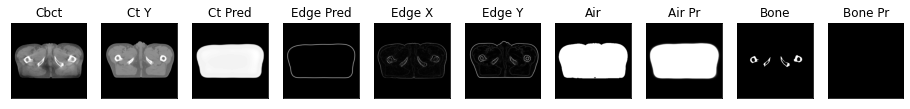

57it [00:30,  1.38it/s]

ssim score = 0.8236663341522217
psnr score = 19.961252212524414
snr score = 10.185580253601074
mae error = 0.03715778887271881
air dice score = 0.9916682847610884
bone dice score = 4.0933278753952794e-11
contour dice score = 0.11080332100391388


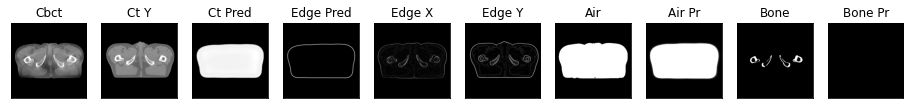

58it [00:31,  1.44it/s]

ssim score = 0.8215674161911011
psnr score = 19.99915885925293
snr score = 10.293888092041016
mae error = 0.037473030388355255
air dice score = 0.9915220733582328
bone dice score = 3.9651070577333427e-11
contour dice score = 0.08738937973976135


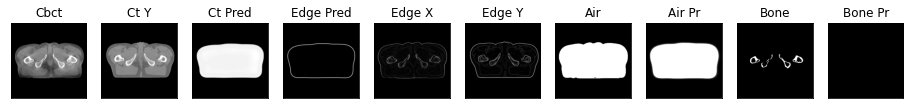

59it [00:32,  1.18it/s]

ssim score = 0.8209058046340942
psnr score = 20.0194149017334
snr score = 10.361711502075195
mae error = 0.03766462579369545
air dice score = 0.9906700742193052
bone dice score = 3.8197097019167415e-11
contour dice score = 0.05286343768239021


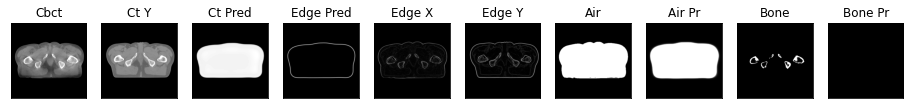

60it [00:33,  1.01s/it]

ssim score = 0.8210428953170776
psnr score = 19.990720748901367
snr score = 10.338632583618164
mae error = 0.03777243569493294
air dice score = 0.9899342323325804
bone dice score = 3.716090672474318e-11
contour dice score = 0.05585392192006111


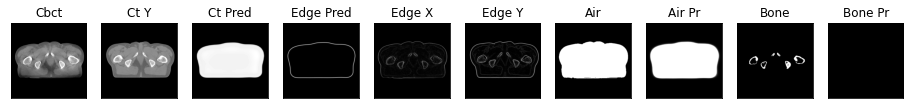

61it [00:36,  1.63s/it]

ssim score = 0.8168885707855225
psnr score = 19.921903610229492
snr score = 10.263311386108398
mae error = 0.03812909126281738
air dice score = 0.9897606174921425
bone dice score = 3.775009437381087e-11
contour dice score = 0.08292945474386215


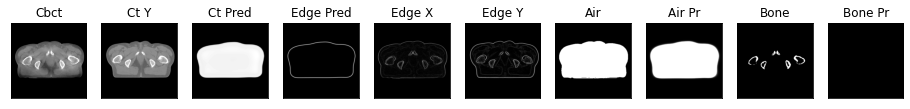

62it [00:37,  1.36s/it]

ssim score = 0.8148877620697021
psnr score = 19.859329223632812
snr score = 10.214847564697266
mae error = 0.038114458322525024
air dice score = 0.9896080502970456
bone dice score = 3.6968576708429996e-11
contour dice score = 0.11397849768400192


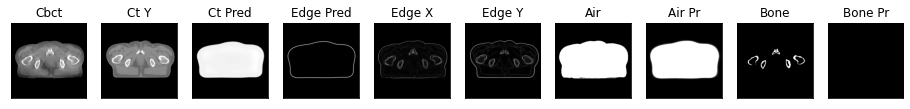

63it [00:38,  1.10s/it]

ssim score = 0.809924304485321
psnr score = 19.661869049072266
snr score = 10.075396537780762
mae error = 0.0386979766190052
air dice score = 0.9901450980731545
bone dice score = 3.2733224221514463e-11
contour dice score = 0.08540540188550949


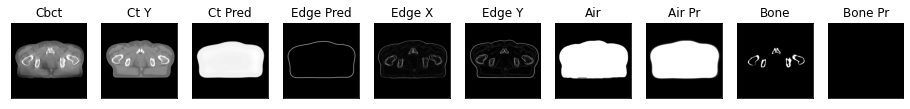

64it [00:38,  1.09it/s]

ssim score = 0.8055803775787354
psnr score = 19.391395568847656
snr score = 9.903480529785156
mae error = 0.040387995541095734
air dice score = 0.9904638619201809
bone dice score = 3.072196620489333e-11
contour dice score = 0.07379679381847382


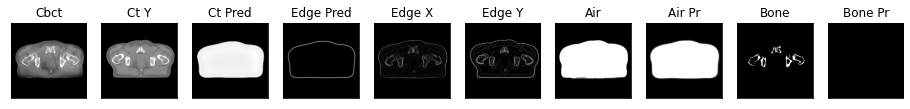

65it [00:38,  1.28it/s]

ssim score = 0.7975278496742249
psnr score = 19.34320068359375
snr score = 9.891117095947266
mae error = 0.04121450334787369
air dice score = 0.9904163258277088
bone dice score = 2.928257686590681e-11
contour dice score = 0.050054408609867096


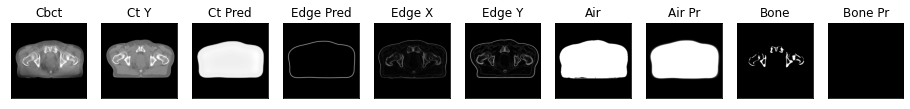

66it [00:39,  1.48it/s]

ssim score = 0.7911062240600586
psnr score = 19.33077621459961
snr score = 9.911396980285645
mae error = 0.042389143258333206
air dice score = 0.9913133224391577
bone dice score = 2.594706798064486e-11
contour dice score = 0.04119241237640381


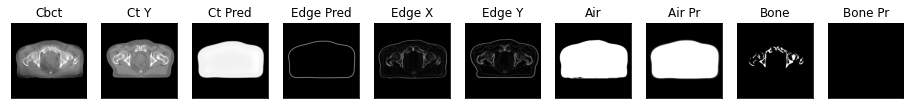

67it [00:39,  1.63it/s]

ssim score = 0.7862820029258728
psnr score = 19.16578483581543
snr score = 9.863224029541016
mae error = 0.044342804700136185
air dice score = 0.9918047589154491
bone dice score = 2.5980774226396966e-11
contour dice score = 0.039487726986408234


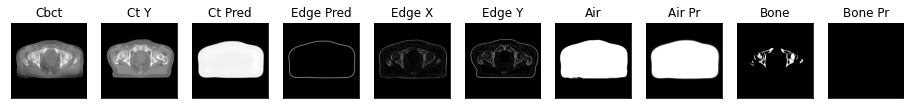

68it [00:40,  1.77it/s]

ssim score = 0.786740779876709
psnr score = 19.218830108642578
snr score = 9.90028190612793
mae error = 0.04408135265111923
air dice score = 0.9924938738661343
bone dice score = 2.884338044335612e-11
contour dice score = 0.0672176331281662


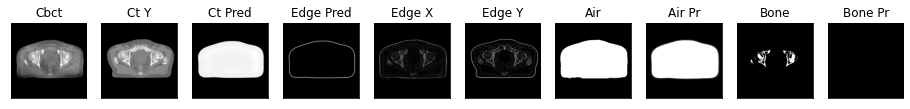

69it [00:40,  1.88it/s]

ssim score = 0.7988545298576355
psnr score = 19.72139549255371
snr score = 10.203683853149414
mae error = 0.04048628732562065
air dice score = 0.9926382792299893
bone dice score = 3.108486167139929e-11
contour dice score = 0.08043478429317474


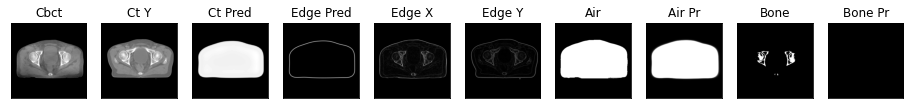

70it [00:41,  1.96it/s]

ssim score = 0.8132466077804565
psnr score = 20.159603118896484
snr score = 10.47149658203125
mae error = 0.0380232110619545
air dice score = 0.9926490747087109
bone dice score = 2.8546959747971826e-11
contour dice score = 0.10337322950363159


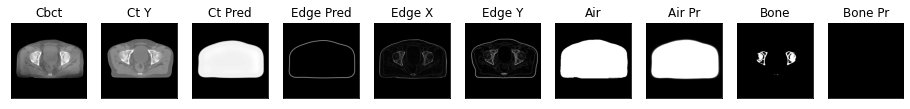

71it [00:42,  1.71it/s]

ssim score = 0.8185930848121643
psnr score = 20.21808433532715
snr score = 10.544149398803711
mae error = 0.03808420151472092
air dice score = 0.9928773955522214
bone dice score = 2.639915522633582e-11
contour dice score = 0.1111111119389534


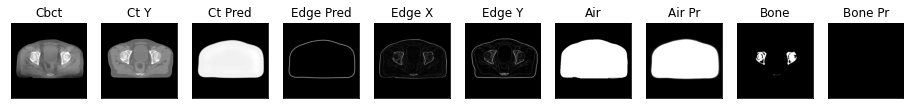

72it [00:42,  1.84it/s]

ssim score = 0.8235567212104797
psnr score = 20.14849090576172
snr score = 10.556382179260254
mae error = 0.038172923028469086
air dice score = 0.9933778220960912
bone dice score = 2.6759432699310692e-11
contour dice score = 0.05482456088066101


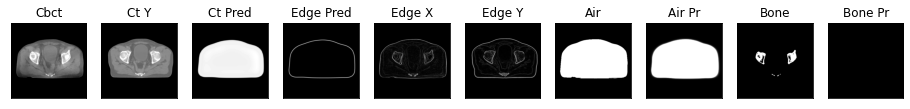

73it [00:42,  1.95it/s]

ssim score = 0.8267176151275635
psnr score = 19.972211837768555
snr score = 10.472277641296387
mae error = 0.03803349286317825
air dice score = 0.9937081250212617
bone dice score = 3.0321406912361387e-11
contour dice score = 0.0679287314414978


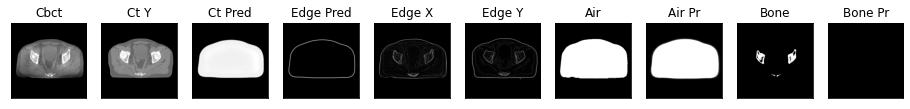

74it [00:43,  2.03it/s]

ssim score = 0.8271670341491699
psnr score = 20.532978057861328
snr score = 10.969615936279297
mae error = 0.036116525530815125
air dice score = 0.9933982491377101
bone dice score = 3.331112591494633e-11
contour dice score = 0.05314533784985542


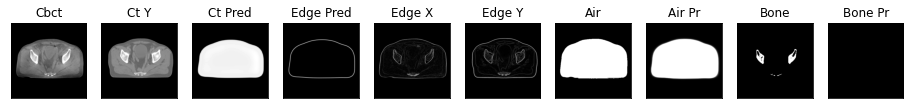

75it [00:43,  2.09it/s]

ssim score = 0.8267563581466675
psnr score = 20.83977508544922
snr score = 11.240019798278809
mae error = 0.0348324216902256
air dice score = 0.9925136404009707
bone dice score = 3.593244699834953e-11
contour dice score = 0.050646550953388214


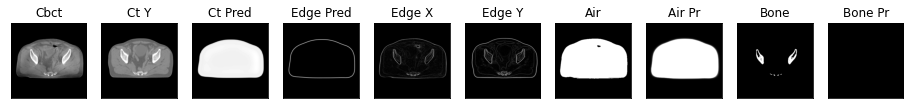

76it [00:44,  2.12it/s]

ssim score = 0.8169195652008057
psnr score = 20.85109519958496
snr score = 11.289085388183594
mae error = 0.03553896024823189
air dice score = 0.9925409739018719
bone dice score = 3.291639236231348e-11
contour dice score = 0.0729222521185875


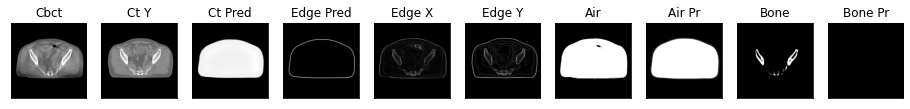

77it [00:44,  2.12it/s]

ssim score = 0.8061909079551697
psnr score = 20.39776611328125
snr score = 10.966261863708496
mae error = 0.03786514699459076
air dice score = 0.993672869569642
bone dice score = 2.8481913983808548e-11
contour dice score = 0.06587473303079605


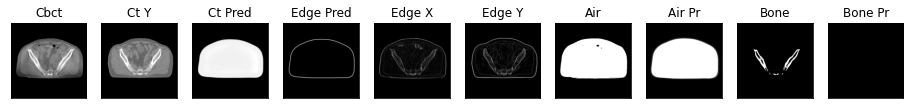

78it [00:45,  2.12it/s]

ssim score = 0.8002896904945374
psnr score = 20.321365356445312
snr score = 10.907607078552246
mae error = 0.03923037648200989
air dice score = 0.9934300551603445
bone dice score = 3.067484662482593e-11
contour dice score = 0.08130080997943878


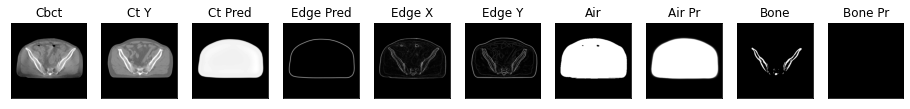

79it [00:45,  2.11it/s]

ssim score = 0.798695981502533
psnr score = 20.43504524230957
snr score = 11.010019302368164
mae error = 0.039015769958496094
air dice score = 0.9939225293203869
bone dice score = 3.379520108030432e-11
contour dice score = 0.09819967299699783


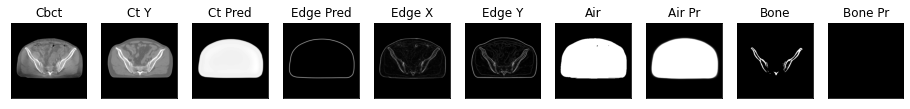

80it [00:46,  2.15it/s]

ssim score = 0.7969577312469482
psnr score = 20.427967071533203
snr score = 11.002201080322266
mae error = 0.038798291236162186
air dice score = 0.9936806411837292
bone dice score = 3.257328990121911e-11
contour dice score = 0.11667583882808685


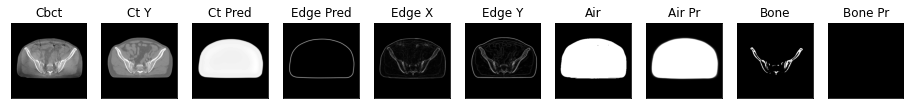

81it [00:46,  1.82it/s]

ssim score = 0.807647705078125
psnr score = 20.55084228515625
snr score = 10.98497486114502
mae error = 0.03672196716070175
air dice score = 0.9894437290345229
bone dice score = 7.745933384372894e-11
contour dice score = 0.015118790790438652


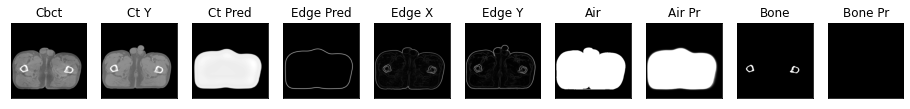

82it [00:47,  1.92it/s]

ssim score = 0.8066964149475098
psnr score = 20.675247192382812
snr score = 11.173773765563965
mae error = 0.036350708454847336
air dice score = 0.9902241033497132
bone dice score = 7.102272726768303e-11
contour dice score = 0.025599999353289604


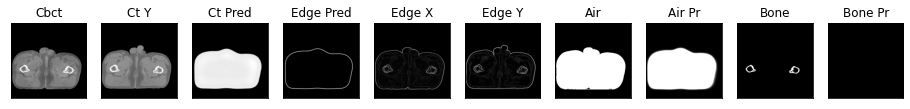

83it [00:47,  2.01it/s]

ssim score = 0.8075555562973022
psnr score = 20.863605499267578
snr score = 11.5013427734375
mae error = 0.036073267459869385
air dice score = 0.9892631085410727
bone dice score = 4.5372050814638294e-11
contour dice score = 0.032460734248161316


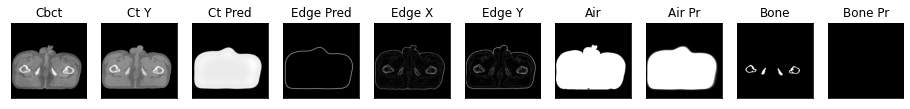

84it [00:48,  2.09it/s]

ssim score = 0.8055520057678223
psnr score = 20.845977783203125
snr score = 11.605209350585938
mae error = 0.03636259585618973
air dice score = 0.9897279181343926
bone dice score = 4.3668122268835455e-11
contour dice score = 0.03169571980834007


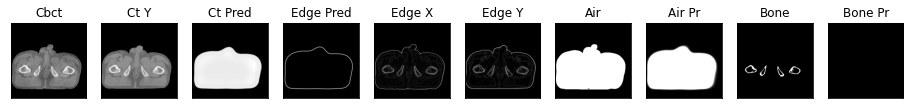

85it [00:48,  2.14it/s]

ssim score = 0.8006191253662109
psnr score = 21.010196685791016
snr score = 11.793600082397461
mae error = 0.03612181916832924
air dice score = 0.990340635998581
bone dice score = 4.504504504301599e-11
contour dice score = 0.03503184765577316


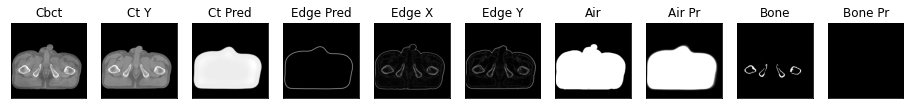

86it [00:49,  2.17it/s]

ssim score = 0.7997943162918091
psnr score = 21.148508071899414
snr score = 11.92751407623291
mae error = 0.03599075227975845
air dice score = 0.9904448003466252
bone dice score = 4.1101520754578645e-11
contour dice score = 0.0490143857896328


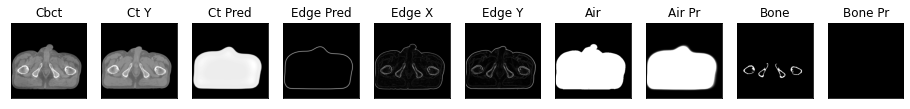

87it [00:49,  2.15it/s]

ssim score = 0.7991029620170593
psnr score = 21.108604431152344
snr score = 11.893865585327148
mae error = 0.036129891872406006
air dice score = 0.9905329647418646
bone dice score = 3.980891719586748e-11
contour dice score = 0.08988764137029648


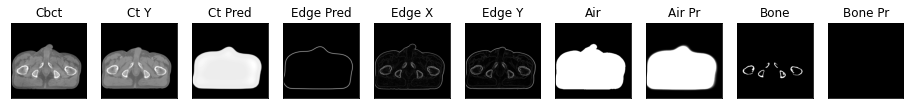

88it [00:50,  2.16it/s]

ssim score = 0.7992907166481018
psnr score = 20.993852615356445
snr score = 11.757556915283203
mae error = 0.03606298938393593
air dice score = 0.9902453717648769
bone dice score = 3.958828186699967e-11
contour dice score = 0.12273212522268295


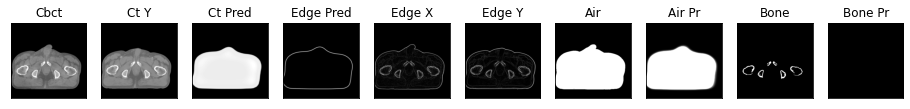

89it [00:50,  2.18it/s]

ssim score = 0.8015941977500916
psnr score = 20.91131019592285
snr score = 11.691924095153809
mae error = 0.036509010940790176
air dice score = 0.9903116971554228
bone dice score = 3.700962250048077e-11
contour dice score = 0.15409310162067413


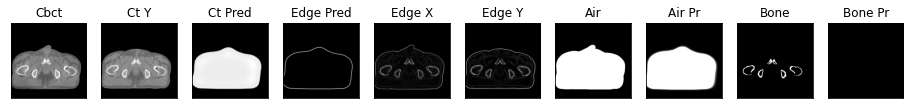

90it [00:50,  2.18it/s]

ssim score = 0.8007612824440002
psnr score = 20.922035217285156
snr score = 11.771245956420898
mae error = 0.0367579460144043
air dice score = 0.99129205409647
bone dice score = 3.36134453770214e-11
contour dice score = 0.19150081276893616


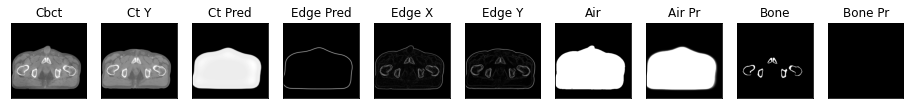

91it [00:51,  1.83it/s]

ssim score = 0.7962761521339417
psnr score = 20.945209503173828
snr score = 11.87578010559082
mae error = 0.036895234137773514
air dice score = 0.9930554471823897
bone dice score = 3.063725490102214e-11
contour dice score = 0.20853592455387115


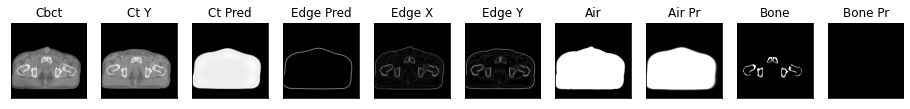

92it [00:52,  1.87it/s]

ssim score = 0.7934778332710266
psnr score = 21.13589096069336
snr score = 12.117158889770508
mae error = 0.03671165183186531
air dice score = 0.9928984724277571
bone dice score = 2.908667830049195e-11
contour dice score = 0.23459459841251373


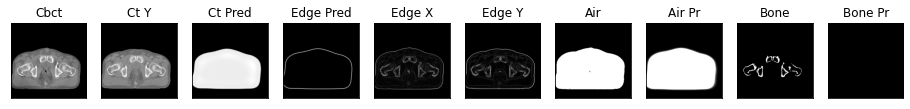

93it [00:52,  1.95it/s]

ssim score = 0.7908868193626404
psnr score = 20.911304473876953
snr score = 12.008843421936035
mae error = 0.03789685666561127
air dice score = 0.9929579123389678
bone dice score = 2.642007925953976e-11
contour dice score = 0.2151351422071457


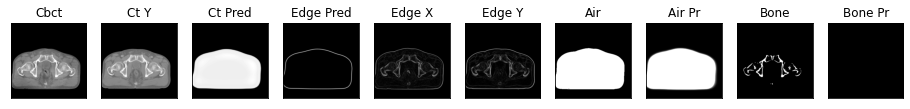

94it [00:53,  2.02it/s]

ssim score = 0.7906516790390015
psnr score = 21.082780838012695
snr score = 12.142084121704102
mae error = 0.03758561238646507
air dice score = 0.9913272258938697
bone dice score = 2.8677946658196788e-11
contour dice score = 0.23064428567886353


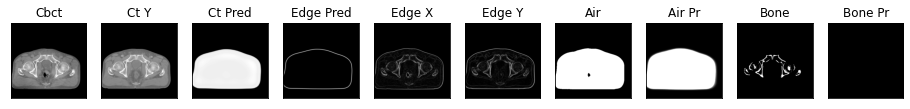

95it [00:53,  2.06it/s]

ssim score = 0.78824782371521
psnr score = 20.408252716064453
snr score = 11.37188720703125
mae error = 0.040030587464571
air dice score = 0.9924237590914952
bone dice score = 2.635046113237548e-11
contour dice score = 0.07934782654047012


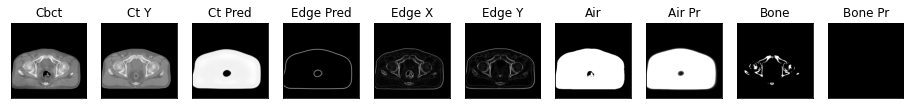

96it [00:54,  2.11it/s]

ssim score = 0.7934710383415222
psnr score = 20.377113342285156
snr score = 11.180988311767578
mae error = 0.038735467940568924
air dice score = 0.9912826698834006
bone dice score = 3.317850033068419e-11
contour dice score = 0.08169934898614883


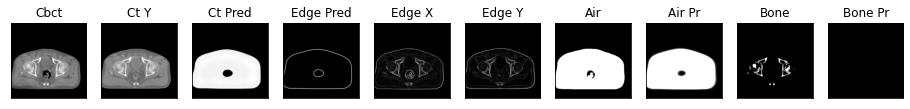

97it [00:54,  2.15it/s]

ssim score = 0.7957882881164551
psnr score = 20.284997940063477
snr score = 10.972447395324707
mae error = 0.03904705122113228
air dice score = 0.9914233917843479
bone dice score = 3.424657534129292e-11
contour dice score = 0.09185346961021423


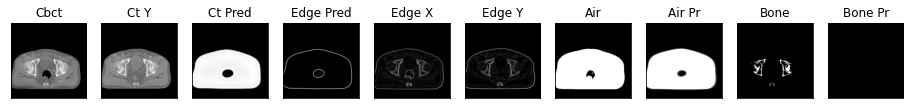

98it [00:54,  2.17it/s]

ssim score = 0.7994751334190369
psnr score = 20.198150634765625
snr score = 10.84050178527832
mae error = 0.04003473371267319
air dice score = 0.9920750577178196
bone dice score = 3.183699458669733e-11
contour dice score = 0.09978070110082626


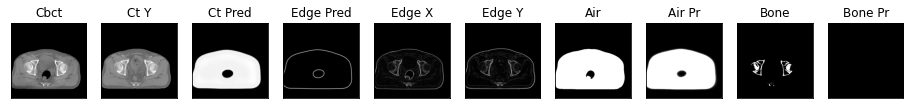

99it [00:55,  2.19it/s]

ssim score = 0.800550103187561
psnr score = 19.84263038635254
snr score = 10.491658210754395
mae error = 0.04147782921791077
air dice score = 0.9928266579120216
bone dice score = 3.183699458669733e-11
contour dice score = 0.09555189311504364


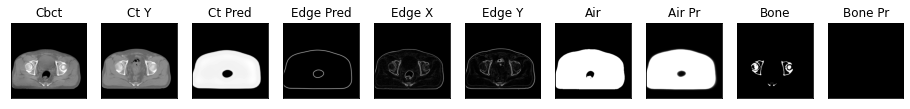

100it [00:55,  2.16it/s]

ssim score = 0.8011593222618103
psnr score = 19.52840232849121
snr score = 10.207533836364746
mae error = 0.0424080565571785
air dice score = 0.9939071018032068
bone dice score = 3.0012004801020045e-11
contour dice score = 0.1077515110373497


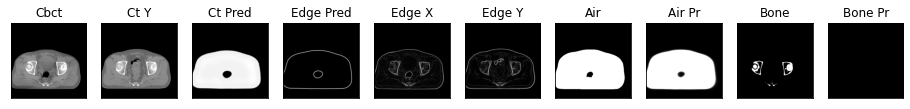

101it [00:56,  1.85it/s]

ssim score = 0.8093093037605286
psnr score = 20.37348175048828
snr score = 11.010028839111328
mae error = 0.038265351206064224
air dice score = 0.9927016844152826
bone dice score = 3.3333333332222224e-11
contour dice score = 0.11434854567050934


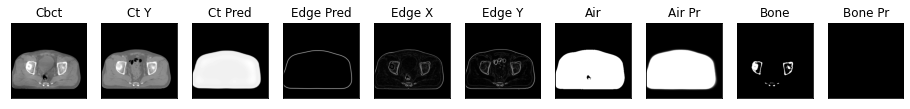

102it [00:57,  1.91it/s]

ssim score = 0.8057383894920349
psnr score = 20.48486328125
snr score = 11.031203269958496
mae error = 0.03754914924502373
air dice score = 0.9942052095577102
bone dice score = 3.736920777139876e-11
contour dice score = 0.1090308353304863


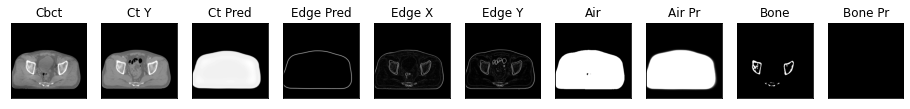

103it [00:57,  1.96it/s]

ssim score = 0.8041932582855225
psnr score = 20.491788864135742
snr score = 10.972403526306152
mae error = 0.0373649001121521
air dice score = 0.9927099420448756
bone dice score = 3.907776475032912e-11
contour dice score = 0.10601877421140671


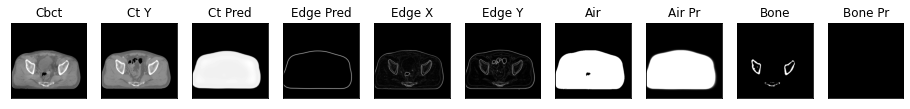

104it [00:57,  2.03it/s]

ssim score = 0.8004336953163147
psnr score = 20.4202823638916
snr score = 10.900593757629395
mae error = 0.03760349005460739
air dice score = 0.9927559265889342
bone dice score = 3.415300546331445e-11
contour dice score = 0.10071942210197449


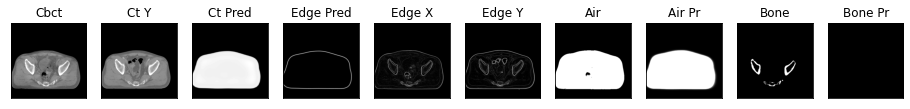

105it [00:58,  2.06it/s]

ssim score = 0.7941213250160217
psnr score = 20.201242446899414
snr score = 10.757722854614258
mae error = 0.03926154971122742
air dice score = 0.991343855826648
bone dice score = 2.778549597033105e-11
contour dice score = 0.08898776769638062


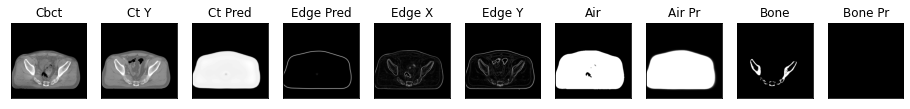

106it [00:58,  2.13it/s]

ssim score = 0.7923909425735474
psnr score = 19.972951889038086
snr score = 10.56501293182373
mae error = 0.040882665663957596
air dice score = 0.9914942431066054
bone dice score = 2.5906735750624178e-11
contour dice score = 0.0800444707274437


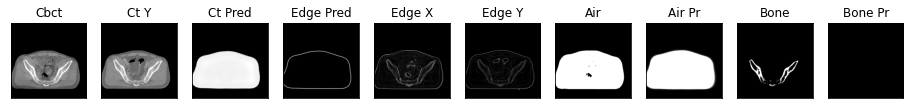

107it [00:59,  2.15it/s]

ssim score = 0.7909789681434631
psnr score = 19.967491149902344
snr score = 10.497856140136719
mae error = 0.04121803864836693
air dice score = 0.9928807352010055
bone dice score = 2.7639579877621902e-11
contour dice score = 0.08156424760818481


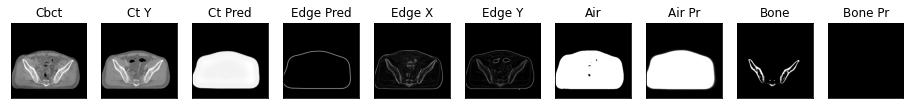

108it [00:59,  2.13it/s]

ssim score = 0.7927232384681702
psnr score = 20.107099533081055
snr score = 10.576202392578125
mae error = 0.04066242277622223
air dice score = 0.9935464945731942
bone dice score = 2.894356005704939e-11
contour dice score = 0.04861503839492798


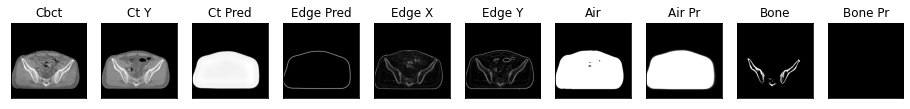

109it [01:00,  2.11it/s]

ssim score = 0.8081707954406738
psnr score = 20.435848236083984
snr score = 12.133153915405273
mae error = 0.045850224792957306
air dice score = 0.9888855262611403
bone dice score = 6.325110689036994e-11
contour dice score = 0.21328513324260712


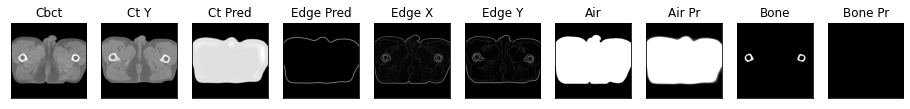

110it [01:00,  2.11it/s]

ssim score = 0.7977040410041809
psnr score = 20.240964889526367
snr score = 12.042561531066895
mae error = 0.04692193120718002
air dice score = 0.990636902866717
bone dice score = 5.681818181495351e-11
contour dice score = 0.23076923191547394


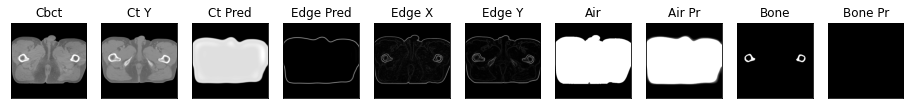

111it [01:01,  1.74it/s]

ssim score = 0.7883419394493103
psnr score = 20.009307861328125
snr score = 11.938861846923828
mae error = 0.04825711250305176
air dice score = 0.9923154143746999
bone dice score = 4.559963520083905e-11
contour dice score = 0.23854875564575195


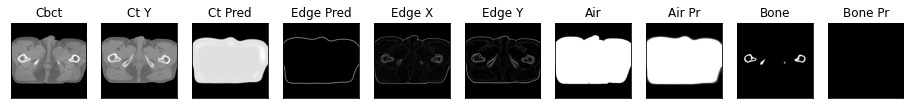

112it [01:02,  1.86it/s]

ssim score = 0.7816253900527954
psnr score = 19.963903427124023
snr score = 11.925745964050293
mae error = 0.048811063170433044
air dice score = 0.9927329915169557
bone dice score = 3.344481605239315e-11
contour dice score = 0.2278710901737213


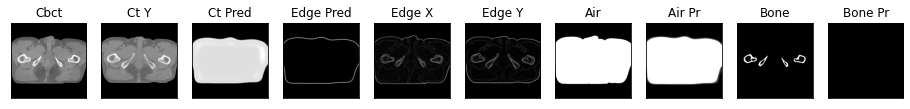

113it [01:02,  1.95it/s]

ssim score = 0.775673508644104
psnr score = 19.73459243774414
snr score = 11.726673126220703
mae error = 0.05055367201566696
air dice score = 0.9925870626454489
bone dice score = 3.231017770493343e-11
contour dice score = 0.23829013109207153


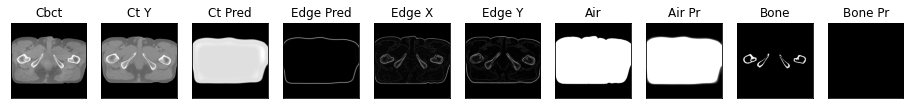

114it [01:02,  2.02it/s]

ssim score = 0.7697135806083679
psnr score = 19.502368927001953
snr score = 11.528865814208984
mae error = 0.0521528497338295
air dice score = 0.9927497892380635
bone dice score = 3.0684258974204225e-11
contour dice score = 0.293769896030426


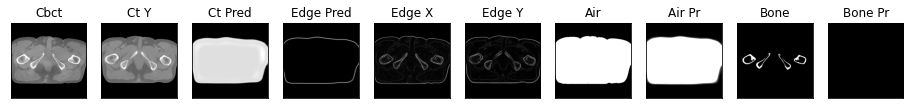

115it [01:03,  2.05it/s]

ssim score = 0.7714835405349731
psnr score = 19.38551139831543
snr score = 11.432318687438965
mae error = 0.052629683166742325
air dice score = 0.9931038476014052
bone dice score = 2.6874496102475827e-11
contour dice score = 0.2825988233089447


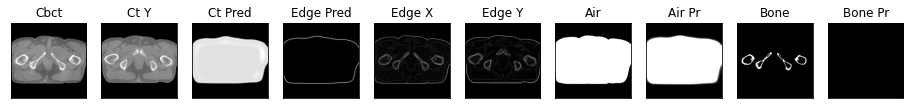

116it [01:03,  2.11it/s]

ssim score = 0.7710102796554565
psnr score = 19.341556549072266
snr score = 11.427438735961914
mae error = 0.05262060835957527
air dice score = 0.9937817126873901
bone dice score = 2.6659557450635575e-11
contour dice score = 0.3001808226108551


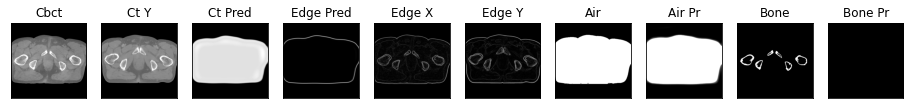

117it [01:04,  2.15it/s]

ssim score = 0.7697588801383972
psnr score = 19.320663452148438
snr score = 11.455223083496094
mae error = 0.0527634434401989
air dice score = 0.9932103406396431
bone dice score = 2.57731958756244e-11
contour dice score = 0.26497596502304077


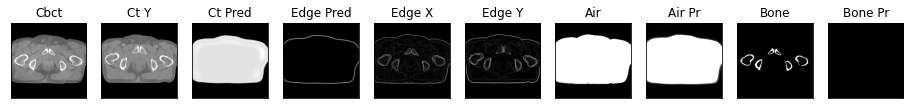

118it [01:04,  2.18it/s]

ssim score = 0.7608810663223267
psnr score = 19.305246353149414
snr score = 11.462417602539062
mae error = 0.0530555285513401
air dice score = 0.9927500593071806
bone dice score = 2.4801587300972182e-11
contour dice score = 0.26603934168815613


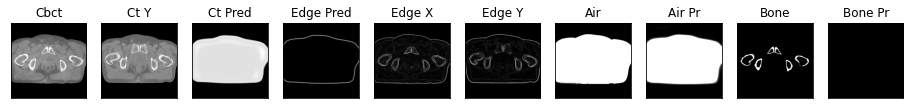

119it [01:05,  2.19it/s]

ssim score = 0.7509781122207642
psnr score = 19.299419403076172
snr score = 11.499370574951172
mae error = 0.05408485233783722
air dice score = 0.9923810403343151
bone dice score = 2.3110700253683597e-11
contour dice score = 0.2869378924369812


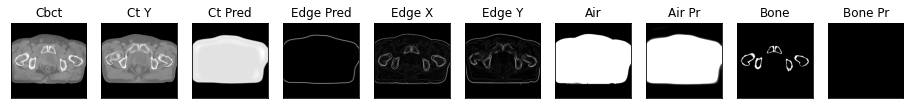

120it [01:05,  2.21it/s]

ssim score = 0.7508842945098877
psnr score = 19.1614933013916
snr score = 11.419780731201172
mae error = 0.05574875324964523
air dice score = 0.9937294886458375
bone dice score = 2.1083702297679026e-11
contour dice score = 0.3020072877407074


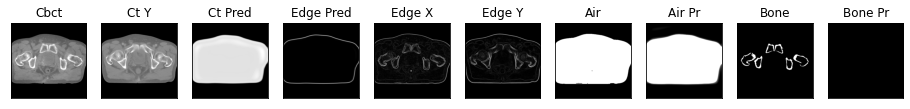

121it [01:06,  1.81it/s]

ssim score = 0.7526634931564331
psnr score = 19.21965789794922
snr score = 11.40257453918457
mae error = 0.055237770080566406
air dice score = 0.9936313048072487
bone dice score = 1.9051247856371665e-11
contour dice score = 0.3324175775051117


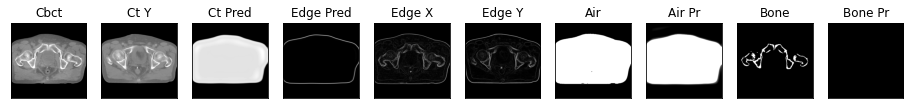

122it [01:06,  1.90it/s]

ssim score = 0.7556514739990234
psnr score = 19.289817810058594
snr score = 11.365517616271973
mae error = 0.05474031716585159
air dice score = 0.9935569745893541
bone dice score = 1.8545994064937944e-11
contour dice score = 0.4075263738632202


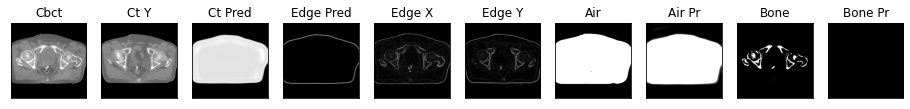

123it [01:07,  1.98it/s]

ssim score = 0.7640600204467773
psnr score = 19.488359451293945
snr score = 11.440969467163086
mae error = 0.05403934419155121
air dice score = 0.9935590534908589
bone dice score = 1.9391118867182643e-11
contour dice score = 0.4360625445842743


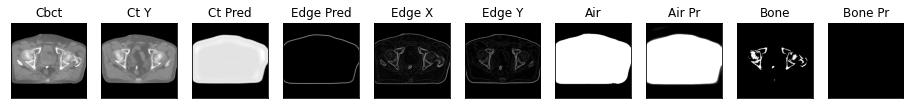

124it [01:07,  2.01it/s]

ssim score = 0.7754356861114502
psnr score = 19.590482711791992
snr score = 11.4306640625
mae error = 0.0540275014936924
air dice score = 0.993690561171625
bone dice score = 2.0395676116247285e-11
contour dice score = 0.4288354814052582


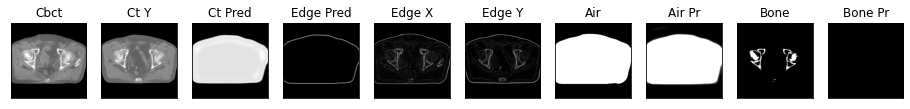

125it [01:08,  2.03it/s]

ssim score = 0.7805699110031128
psnr score = 19.621177673339844
snr score = 11.410711288452148
mae error = 0.05409708991646767
air dice score = 0.9935908899490654
bone dice score = 2.0104543626455478e-11
contour dice score = 0.4302974045276642


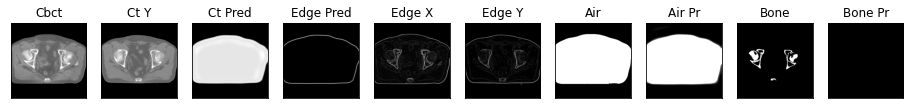

126it [01:08,  2.03it/s]

ssim score = 0.78148353099823
psnr score = 19.538545608520508
snr score = 11.360234260559082
mae error = 0.05426320433616638
air dice score = 0.9936010923271001
bone dice score = 2.1263023601504083e-11
contour dice score = 0.4302379786968231


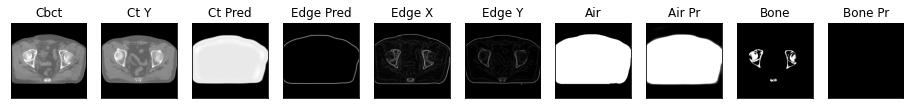

127it [01:09,  2.08it/s]

ssim score = 0.7777746319770813
psnr score = 19.310394287109375
snr score = 11.145562171936035
mae error = 0.054667603224515915
air dice score = 0.9939241006796903
bone dice score = 2.2983222247230908e-11
contour dice score = 0.37124061584472656


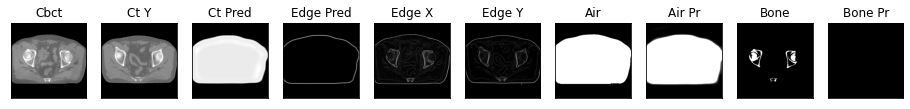

128it [01:09,  2.08it/s]

ssim score = 0.7794265747070312
psnr score = 19.539928436279297
snr score = 11.233604431152344
mae error = 0.0535346157848835
air dice score = 0.9933512585745372
bone dice score = 2.2810218977581884e-11
contour dice score = 0.2674253284931183


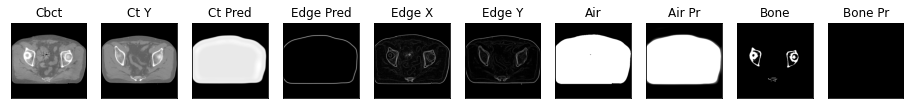

129it [01:10,  2.12it/s]

ssim score = 0.7840973138809204
psnr score = 19.68660545349121
snr score = 11.320971488952637
mae error = 0.05215560272336006
air dice score = 0.99366097749736
bone dice score = 2.6745119015064317e-11
contour dice score = 0.13904762268066406


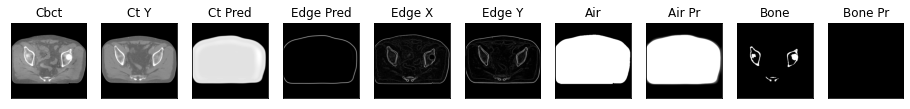

130it [01:10,  2.17it/s]

ssim score = 0.7824141383171082
psnr score = 19.70642852783203
snr score = 11.366442680358887
mae error = 0.050442636013031006
air dice score = 0.9936358671131096
bone dice score = 3.707823507463559e-11
contour dice score = 0.13244402408599854


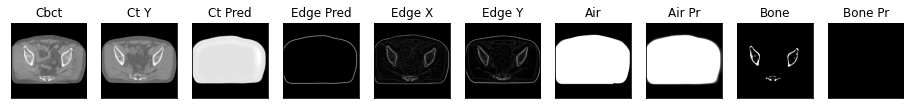

131it [01:11,  1.84it/s]

ssim score = 0.7835148572921753
psnr score = 19.735923767089844
snr score = 11.46875
mae error = 0.049662403762340546
air dice score = 0.9934116299054752
bone dice score = 3.449465332754417e-11
contour dice score = 0.1192748099565506


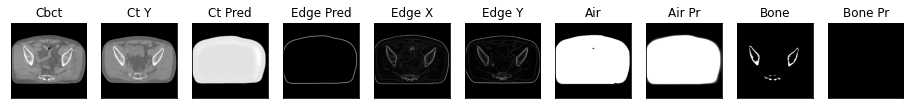

132it [01:11,  1.93it/s]

ssim score = 0.7771261930465698
psnr score = 19.590572357177734
snr score = 11.452630996704102
mae error = 0.05086027458310127
air dice score = 0.992818369601772
bone dice score = 3.211303789235347e-11
contour dice score = 0.10758885741233826


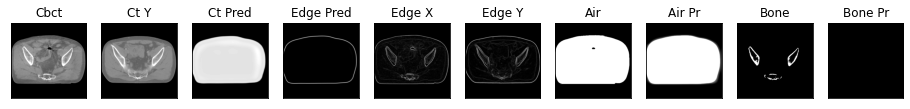

133it [01:12,  1.99it/s]

ssim score = 0.7680596113204956
psnr score = 19.646568298339844
snr score = 11.542586326599121
mae error = 0.05065310746431351
air dice score = 0.9923145190989983
bone dice score = 2.913752913668014e-11
contour dice score = 0.0974903479218483


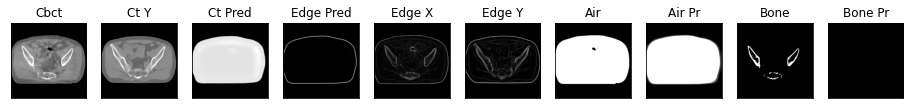

134it [01:12,  2.05it/s]

ssim score = 0.7665137648582458
psnr score = 19.7993221282959
snr score = 11.665550231933594
mae error = 0.049987196922302246
air dice score = 0.9930053851273716
bone dice score = 2.358490565982111e-11
contour dice score = 0.09196514636278152


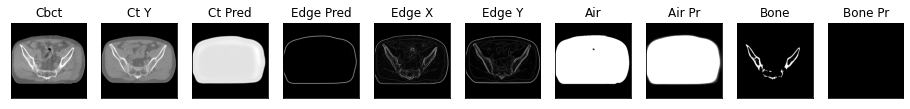

135it [01:13,  2.03it/s]

ssim score = 0.7659807801246643
psnr score = 19.897958755493164
snr score = 11.700810432434082
mae error = 0.04923812672495842
air dice score = 0.9928417473665081
bone dice score = 2.581311306076889e-11
contour dice score = 0.09223300963640213


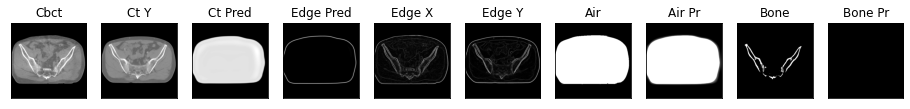

136it [01:13,  2.04it/s]

ssim score = 0.768619179725647
psnr score = 19.414918899536133
snr score = 10.892311096191406
mae error = 0.0444684773683548
air dice score = 0.9941321415093685
bone dice score = 2.3546032492970425e-11
contour dice score = 0.08611955493688583


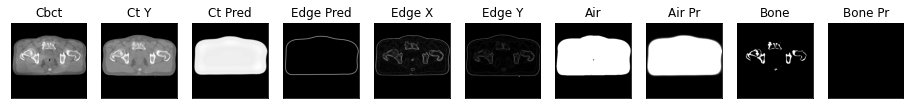

137it [01:14,  2.04it/s]

ssim score = 0.7612850666046143
psnr score = 19.269655227661133
snr score = 10.787059783935547
mae error = 0.045429375022649765
air dice score = 0.9942000178004612
bone dice score = 2.4479804160967446e-11
contour dice score = 0.05490594729781151


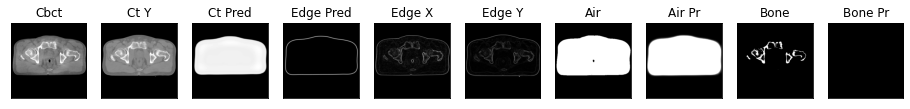

138it [01:14,  2.10it/s]

ssim score = 0.7605090737342834
psnr score = 19.275028228759766
snr score = 10.80021858215332
mae error = 0.0455445796251297
air dice score = 0.9945360066014002
bone dice score = 2.5484199795476957e-11
contour dice score = 0.03471158817410469


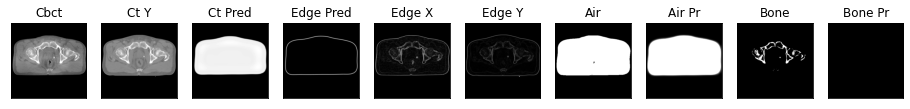

139it [01:15,  2.11it/s]

ssim score = 0.7662765383720398
psnr score = 19.371843338012695
snr score = 10.838614463806152
mae error = 0.04460620507597923
air dice score = 0.9940306293549994
bone dice score = 2.427184465960505e-11
contour dice score = 0.0235294122248888


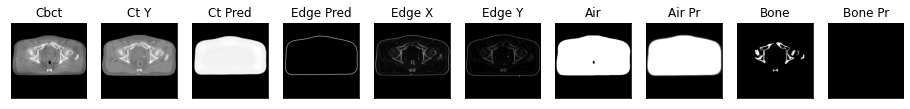

140it [01:15,  2.17it/s]

ssim score = 0.7759446501731873
psnr score = 19.578386306762695
snr score = 10.889531135559082
mae error = 0.04191838577389717
air dice score = 0.9943241224794666
bone dice score = 2.960331557046764e-11
contour dice score = 0.0195172056555748


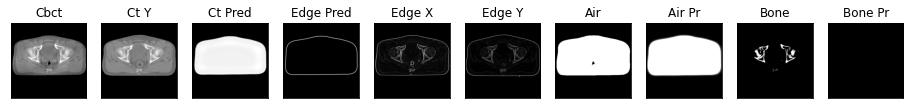

141it [01:16,  1.87it/s]

ssim score = 0.7777070999145508
psnr score = 19.475078582763672
snr score = 10.765422821044922
mae error = 0.04217271879315376
air dice score = 0.9943181818181861
bone dice score = 2.7601435273872442e-11
contour dice score = 0.019587628543376923


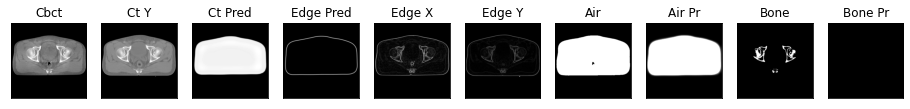

142it [01:16,  1.90it/s]

ssim score = 0.7833257913589478
psnr score = 19.457143783569336
snr score = 10.731855392456055
mae error = 0.04223381355404854
air dice score = 0.9942561573391918
bone dice score = 2.7352297592249663e-11
contour dice score = 0.022762544453144073


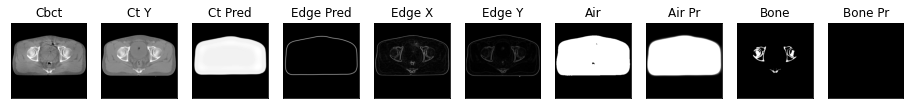

143it [01:17,  1.98it/s]

ssim score = 0.7847737669944763
psnr score = 19.179216384887695
snr score = 10.463294982910156
mae error = 0.043711405247449875
air dice score = 0.9943240999320746
bone dice score = 2.7210884353001064e-11
contour dice score = 0.016614746302366257


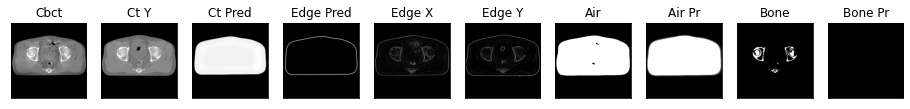

144it [01:17,  2.04it/s]

ssim score = 0.7855527997016907
psnr score = 18.960803985595703
snr score = 10.300662994384766
mae error = 0.04469793289899826
air dice score = 0.994442509502253
bone dice score = 2.6666666665955555e-11
contour dice score = 0.01770833320915699


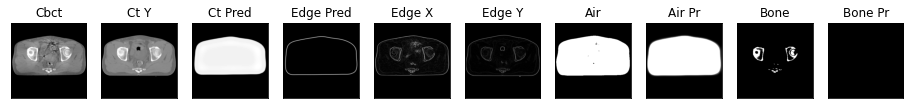

145it [01:18,  2.02it/s]

ssim score = 0.7835767269134521
psnr score = 18.77772331237793
snr score = 10.095651626586914
mae error = 0.045439835637807846
air dice score = 0.9938512286142129
bone dice score = 2.7389756230419344e-11
contour dice score = 0.017773130908608437


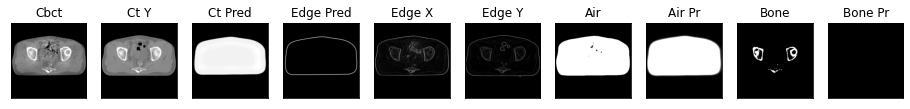

146it [01:18,  2.08it/s]

ssim score = 0.7816975712776184
psnr score = 18.766233444213867
snr score = 10.013388633728027
mae error = 0.045229535549879074
air dice score = 0.9938949566702028
bone dice score = 3.041362530321127e-11
contour dice score = 0.017838405445218086


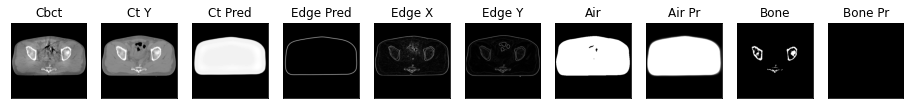

147it [01:19,  2.07it/s]

ssim score = 0.7800502181053162
psnr score = 18.866077423095703
snr score = 10.069337844848633
mae error = 0.04462677985429764
air dice score = 0.9947024518335359
bone dice score = 3.231017770493343e-11
contour dice score = 0.01685985177755356


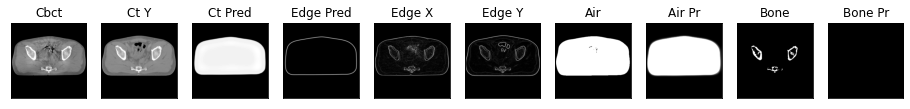

148it [01:19,  2.02it/s]

ssim score = 0.7810081839561462
psnr score = 18.975927352905273
snr score = 10.178091049194336
mae error = 0.04376410320401192
air dice score = 0.9942020327351592
bone dice score = 3.127932436561528e-11
contour dice score = 0.020084567368030548


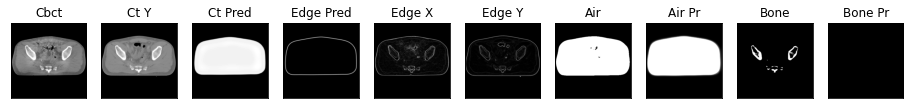

149it [01:20,  2.05it/s]

ssim score = 0.7784168720245361
psnr score = 19.05812644958496
snr score = 10.273648262023926
mae error = 0.04385983943939209
air dice score = 0.9934509900381308
bone dice score = 2.999400119886041e-11
contour dice score = 0.007415254134684801


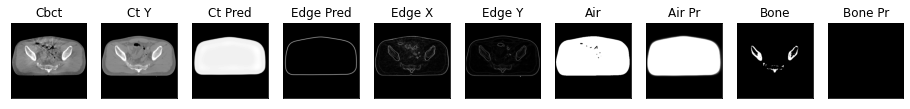

150it [01:20,  2.06it/s]

ssim score = 0.7714561820030212
psnr score = 18.909975051879883
snr score = 10.18070125579834
mae error = 0.044945087283849716
air dice score = 0.9921873192401784
bone dice score = 2.501250625250094e-11
contour dice score = 5.310674469627408e-11


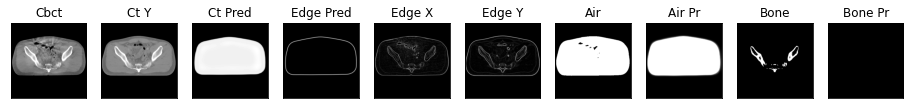

151it [01:21,  1.74it/s]

ssim score = 0.7673764228820801
psnr score = 18.727828979492188
snr score = 10.017924308776855
mae error = 0.0464877225458622
air dice score = 0.9923347963157628
bone dice score = 2.5595085742882133e-11
contour dice score = 0.008510638028383255


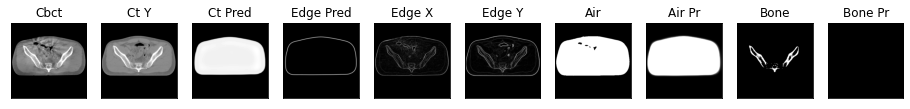

152it [01:21,  1.83it/s]

ssim score = 0.7648200392723083
psnr score = 18.624984741210938
snr score = 9.860342979431152
mae error = 0.04772995039820671
air dice score = 0.9930232198381936
bone dice score = 2.8042624788893925e-11
contour dice score = 0.010678056627511978


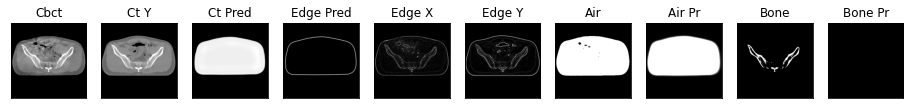

153it [01:22,  1.88it/s]

ssim score = 0.7611002922058105
psnr score = 18.58245086669922
snr score = 9.781454086303711
mae error = 0.048375409096479416
air dice score = 0.9948091933749567
bone dice score = 2.801120448100809e-11
contour dice score = 0.010723860934376717


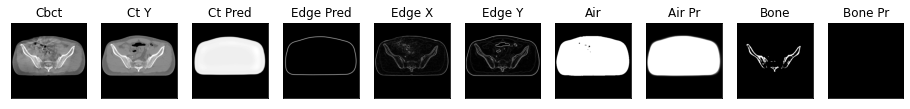

154it [01:22,  1.96it/s]

ssim score = 0.7596361041069031
psnr score = 18.528711318969727
snr score = 9.727787017822266
mae error = 0.04913434013724327
air dice score = 0.9946101663414223
bone dice score = 2.5252525251887564e-11
contour dice score = 0.006465517450124025


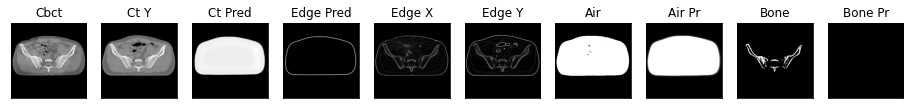

155it [01:23,  2.01it/s]

ssim score = 0.7590926885604858
psnr score = 18.7176513671875
snr score = 9.915306091308594
mae error = 0.04884122684597969
air dice score = 0.9940385286251451
bone dice score = 2.552322613513213e-11
contour dice score = 0.011911207810044289


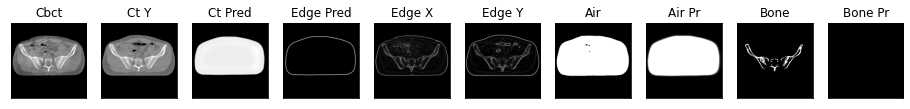

156it [01:23,  2.07it/s]

ssim score = 0.7576712369918823
psnr score = 18.646442413330078
snr score = 9.849137306213379
mae error = 0.04927558824419975
air dice score = 0.9928222974862561
bone dice score = 2.570033410368285e-11
contour dice score = 0.023952096700668335


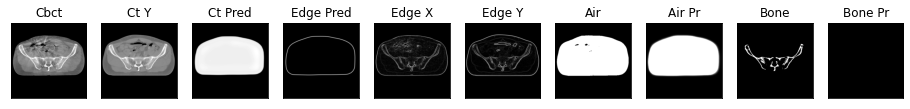

157it [01:24,  2.10it/s]

ssim score = 0.7582738995552063
psnr score = 18.596174240112305
snr score = 9.781594276428223
mae error = 0.050082266330718994
air dice score = 0.9914076753941464
bone dice score = 2.5753283542988583e-11
contour dice score = 0.02849315106868744


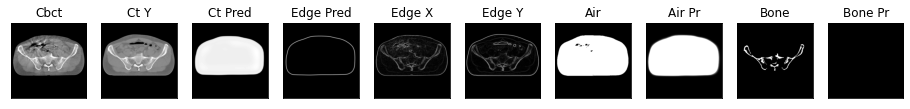

158it [01:24,  2.12it/s]

ssim score = 0.7535770535469055
psnr score = 18.318588256835938
snr score = 9.48538589477539
mae error = 0.05246616154909134
air dice score = 0.9891773704380076
bone dice score = 2.3992322456238187e-11
contour dice score = 0.022075055167078972


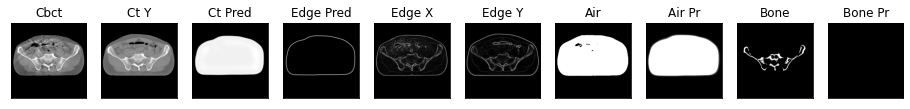

159it [01:25,  2.11it/s]

ssim score = 0.7492486238479614
psnr score = 18.285245895385742
snr score = 9.406105041503906
mae error = 0.05319639667868614
air dice score = 0.989866691745241
bone dice score = 2.3137436371514637e-11
contour dice score = 0.03438713401556015


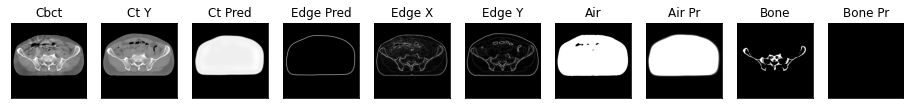

160it [01:25,  2.08it/s]

ssim score = 0.7516186833381653
psnr score = 18.44635772705078
snr score = 9.513420104980469
mae error = 0.052686240524053574
air dice score = 0.9892364905770238
bone dice score = 2.277385561323676e-11
contour dice score = 0.03346347063779831


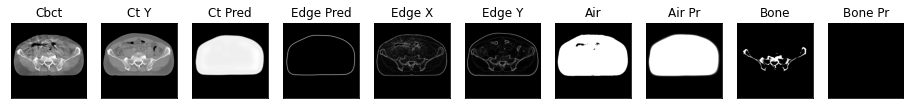

161it [01:26,  1.82it/s]

ssim score = 0.749301016330719
psnr score = 18.22873878479004
snr score = 9.326264381408691
mae error = 0.05440063029527664
air dice score = 0.98800558319994
bone dice score = 2.228660574944759e-11
contour dice score = 0.031319908797740936


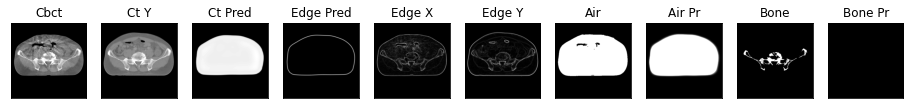

162it [01:26,  1.88it/s]

ssim score = 0.7487356662750244
psnr score = 18.077075958251953
snr score = 9.119375228881836
mae error = 0.05518495291471481
air dice score = 0.9879170595273091
bone dice score = 2.3148148147612312e-11
contour dice score = 0.023450586944818497


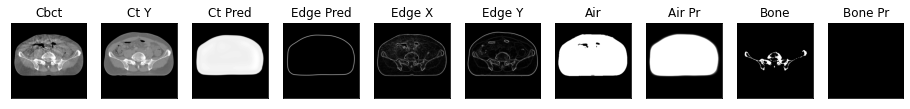

163it [01:27,  1.90it/s]

ssim score = 0.7554761171340942
psnr score = 18.365467071533203
snr score = 9.260232925415039
mae error = 0.053177423775196075
air dice score = 0.9871958008589254
bone dice score = 2.4425989251968098e-11
contour dice score = 0.02021336369216442


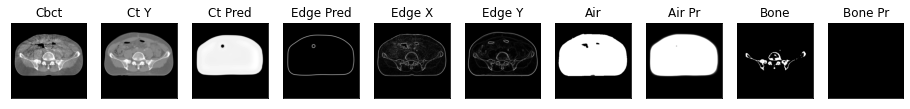

164it [01:27,  1.99it/s]

ssim score = 0.7990177869796753
psnr score = 20.283130645751953
snr score = 10.664043426513672
mae error = 0.046174995601177216
air dice score = 0.9903903015966955
bone dice score = 5.515719801129855e-11
contour dice score = 0.006856023333966732


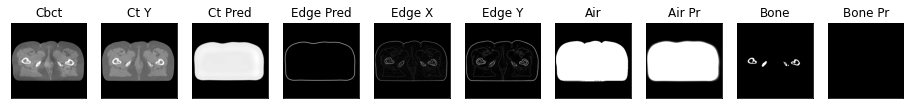

165it [01:28,  2.05it/s]

ssim score = 0.7932037115097046
psnr score = 20.1229305267334
snr score = 10.624856948852539
mae error = 0.04690947011113167
air dice score = 0.9904882222891503
bone dice score = 4.6554934820923885e-11
contour dice score = 0.005991013254970312


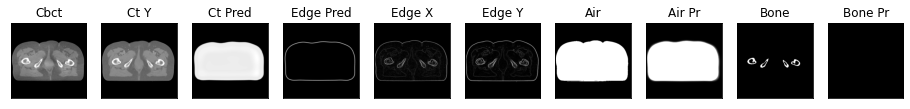

166it [01:28,  2.12it/s]

ssim score = 0.7873410582542419
psnr score = 20.106019973754883
snr score = 10.6908597946167
mae error = 0.047046270221471786
air dice score = 0.9905042734418976
bone dice score = 4.1666666664930555e-11
contour dice score = 0.011828486807644367


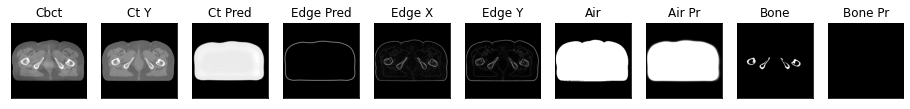

167it [01:29,  2.11it/s]

ssim score = 0.7839266657829285
psnr score = 20.035104751586914
snr score = 10.683389663696289
mae error = 0.04759509116411209
air dice score = 0.9906846052755842
bone dice score = 3.703703703566529e-11
contour dice score = 0.016748769208788872


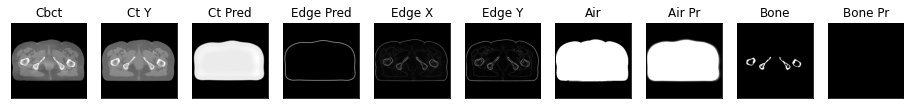

168it [01:29,  2.16it/s]

ssim score = 0.7827130556106567
psnr score = 19.93811798095703
snr score = 10.614867210388184
mae error = 0.04829573631286621
air dice score = 0.9908765329378209
bone dice score = 3.527336860545773e-11
contour dice score = 0.019851116463541985


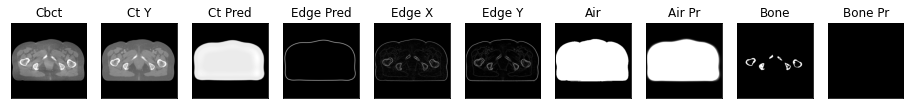

169it [01:29,  2.25it/s]

ssim score = 0.7835115790367126
psnr score = 19.888935089111328
snr score = 10.588638305664062
mae error = 0.04850722476840019
air dice score = 0.9904984693582926
bone dice score = 3.688675765264158e-11
contour dice score = 0.02552773617208004


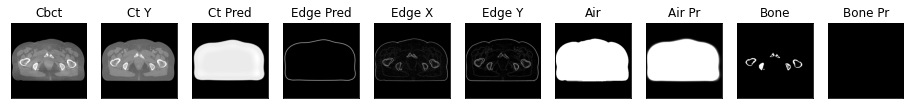

170it [01:30,  2.28it/s]

ssim score = 0.7801918387413025
psnr score = 19.917865753173828
snr score = 10.648895263671875
mae error = 0.04833877831697464
air dice score = 0.9909780174679471
bone dice score = 3.631082062322764e-11
contour dice score = 0.024378351867198944


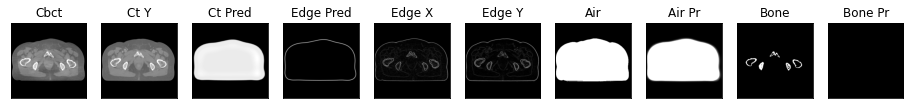

171it [01:31,  1.97it/s]

ssim score = 0.7759909629821777
psnr score = 19.84565544128418
snr score = 10.625048637390137
mae error = 0.04866132140159607
air dice score = 0.9915955511779949
bone dice score = 3.547357218746103e-11
contour dice score = 0.040758293122053146


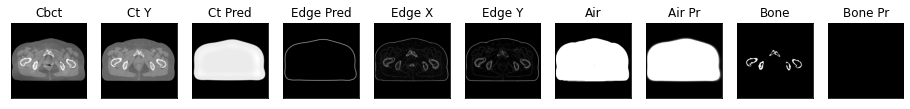

172it [01:31,  2.07it/s]

ssim score = 0.7730680704116821
psnr score = 19.761821746826172
snr score = 10.58395767211914
mae error = 0.049018874764442444
air dice score = 0.9911307247793526
bone dice score = 3.3090668430407324e-11
contour dice score = 0.033898305147886276


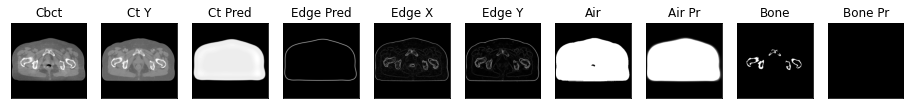

173it [01:31,  2.14it/s]

ssim score = 0.7658599615097046
psnr score = 19.634634017944336
snr score = 10.544472694396973
mae error = 0.05002293363213539
air dice score = 0.9908479641389681
bone dice score = 2.8352707682779906e-11
contour dice score = 0.02919020690023899


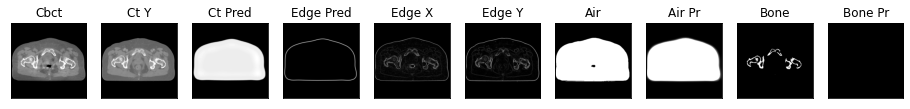

174it [01:32,  2.19it/s]

ssim score = 0.765591025352478
psnr score = 19.520605087280273
snr score = 10.543718338012695
mae error = 0.0506008043885231
air dice score = 0.9915877269665719
bone dice score = 2.341372043962974e-11
contour dice score = 0.035348836332559586


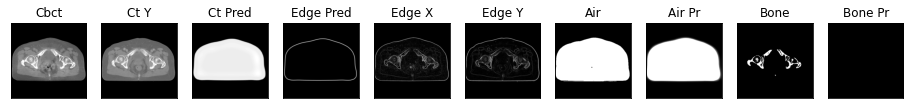

175it [01:32,  2.23it/s]

ssim score = 0.771927535533905
psnr score = 20.023420333862305
snr score = 10.91797924041748
mae error = 0.047439854592084885
air dice score = 0.9908890668802628
bone dice score = 3.394433129552124e-11
contour dice score = 0.034450650215148926


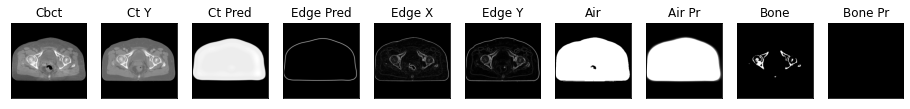

176it [01:33,  2.26it/s]

ssim score = 0.774013340473175
psnr score = 19.8978214263916
snr score = 10.682960510253906
mae error = 0.047573767602443695
air dice score = 0.9905613156953946
bone dice score = 3.8654812522665065e-11
contour dice score = 0.036740463227033615


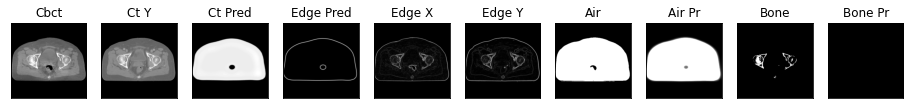

177it [01:33,  2.29it/s]

ssim score = 0.779750645160675
psnr score = 19.908613204956055
snr score = 10.666624069213867
mae error = 0.04830056056380272
air dice score = 0.9899398383824072
bone dice score = 3.427004797689273e-11
contour dice score = 0.06460544466972351


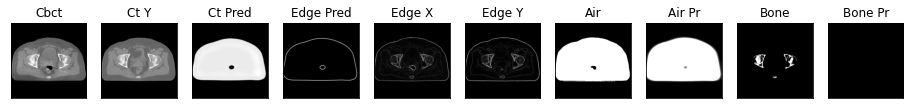

178it [01:34,  2.30it/s]

ssim score = 0.7883047461509705
psnr score = 20.136594772338867
snr score = 10.886602401733398
mae error = 0.04831008240580559
air dice score = 0.9909727912299106
bone dice score = 3.3222591361022506e-11
contour dice score = 0.10531264543533325


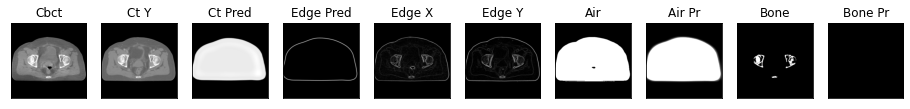

179it [01:34,  2.32it/s]

ssim score = 0.789997398853302
psnr score = 19.934677124023438
snr score = 10.718913078308105
mae error = 0.04963918402791023
air dice score = 0.9910308236483135
bone dice score = 3.164556961925172e-11
contour dice score = 0.11184833943843842


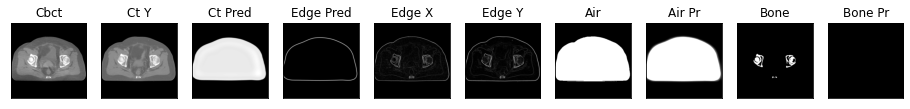

180it [01:34,  2.33it/s]

ssim score = 0.7866523265838623
psnr score = 19.549875259399414
snr score = 10.385601043701172
mae error = 0.051506560295820236
air dice score = 0.9915682967959587
bone dice score = 3.162555344618515e-11
contour dice score = 0.1134270504117012


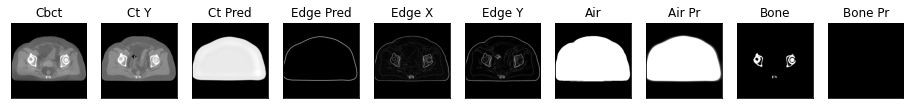

181it [01:35,  2.01it/s]

ssim score = 0.7738502621650696
psnr score = 19.29170799255371
snr score = 10.164995193481445
mae error = 0.052628956735134125
air dice score = 0.9921471035531646
bone dice score = 3.448275861950059e-11
contour dice score = 0.10126582533121109


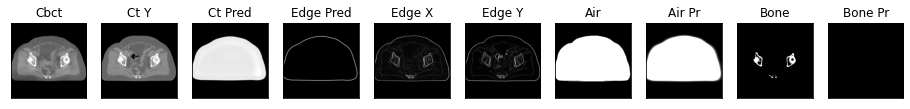

182it [01:36,  2.09it/s]

ssim score = 0.7657575607299805
psnr score = 19.23016357421875
snr score = 10.031014442443848
mae error = 0.0537932887673378
air dice score = 0.9923352209622847
bone dice score = 4.456327985541162e-11
contour dice score = 0.10656142234802246


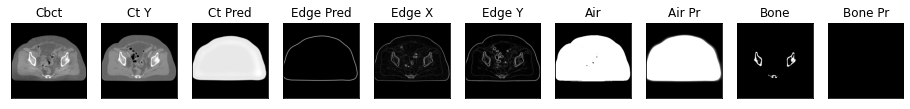

183it [01:36,  2.15it/s]

ssim score = 0.7681633234024048
psnr score = 19.316734313964844
snr score = 10.099592208862305
mae error = 0.053779490292072296
air dice score = 0.9911467116357564
bone dice score = 4.468275245555484e-11
contour dice score = 0.10667996108531952


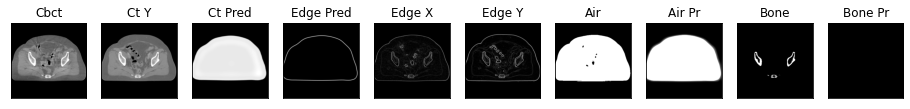

184it [01:36,  2.18it/s]

ssim score = 0.7711975574493408
psnr score = 19.44901466369629
snr score = 10.296785354614258
mae error = 0.05320681631565094
air dice score = 0.9921975015834138
bone dice score = 4.2863266179045725e-11
contour dice score = 0.09960159659385681


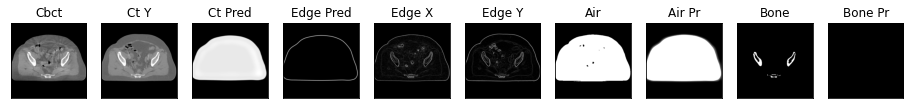

185it [01:37,  2.11it/s]

ssim score = 0.7646833062171936
psnr score = 19.149555206298828
snr score = 10.052419662475586
mae error = 0.055624235421419144
air dice score = 0.9921979372628706
bone dice score = 3.6656891494257445e-11
contour dice score = 0.09628886729478836


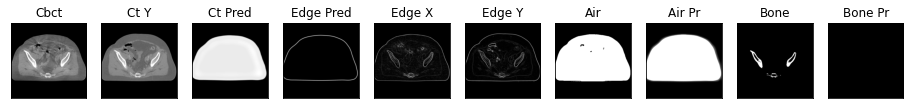

186it [01:38,  1.89it/s]

ssim score = 0.7562191486358643
psnr score = 18.81402587890625
snr score = 9.78132152557373
mae error = 0.0581509992480278
air dice score = 0.9912153337178755
bone dice score = 3.059975520102204e-11
contour dice score = 0.08919722586870193


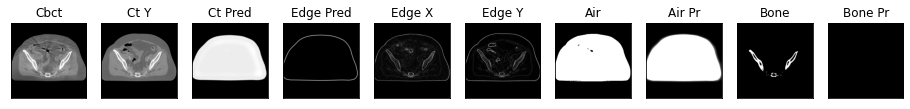

187it [01:38,  1.77it/s]

ssim score = 0.7526392340660095
psnr score = 18.838041305541992
snr score = 9.878195762634277
mae error = 0.05845136195421219
air dice score = 0.9906374921102523
bone dice score = 2.839295854547436e-11
contour dice score = 0.0974155068397522


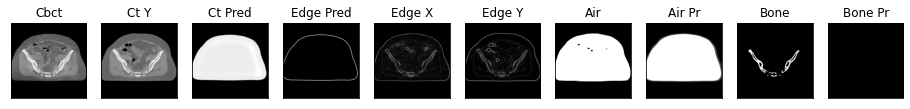

188it [01:39,  1.75it/s]

ssim score = 0.749477744102478
psnr score = 18.95322036743164
snr score = 9.989084243774414
mae error = 0.05851023644208908
air dice score = 0.9908289172647159
bone dice score = 2.908667830049195e-11
contour dice score = 0.09739301353693008


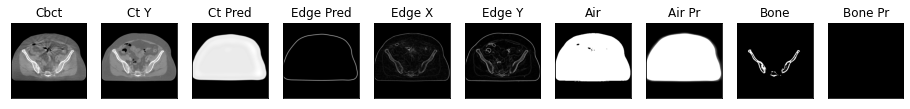

189it [01:39,  1.83it/s]

ssim score = 0.7474852800369263
psnr score = 18.92432403564453
snr score = 9.938010215759277
mae error = 0.05942298471927643
air dice score = 0.9923687778423447
bone dice score = 2.8145229382827323e-11
contour dice score = 0.09775171428918839


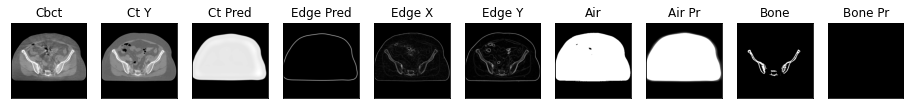

190it [01:40,  1.94it/s]

ssim score = 0.74886155128479
psnr score = 19.122774124145508
snr score = 10.148094177246094
mae error = 0.058917198330163956
air dice score = 0.9927823497390292
bone dice score = 2.935995302321315e-11
contour dice score = 0.09117361903190613


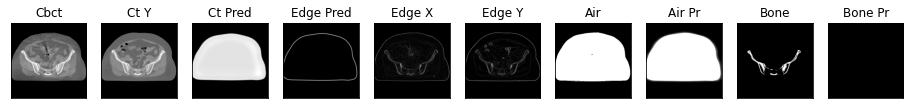

191it [01:41,  1.89it/s]


In [42]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [43]:
discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator)

In [44]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [45]:
# score_ssim, score_psnr, score_snr, score_mae, score_air, score_bone, score_cont, score_acc
# unmasked
eval_epoch(model, discriminator, testloader, device)

191it [00:21,  8.95it/s]


(0.7933029741516913,
 19.88325873969113,
 10.887530756246358,
 0.044326779798297355,
 0.991689520763344,
 2.9564617685948747e-11,
 0.1376822482704659,
 0.49214659685863876)

In [46]:
# import torchvision.models as models
# models.vgg16(pretrained=True)